## Code required to create Figure 4
*From "Exploring uncertainty of trends in the lower-tropospheric North Pacific Jet."* 

Entire notebook takes ~35 minutes to run on Intel i7-10750 using 32GB RAM  

Note: figure 4 is towards the end of the notebook


In [154]:
import collections
import datetime
import glob
import re
import os
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors
import matplotlib.transforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats

sns.set_context('paper')

# Functions to load CMIP6 runs

In [2]:
def make_combined_df_from_data_paths(data_paths, ignored_data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["time", data_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            # print(f)
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_for_bracegirdle(data_paths, ignored_data_paths, data_name=None):
    first_ind = 0 ## FIX: what if first value is not enough days (I am leaving for now, but could use recursion)
    df = pd.read_csv(data_paths[first_ind])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[first_ind])[-1].split("_")[2] + "_" + os.path.split(data_paths[first_ind])[-1].split("_")[4]
        wrote_data_name = True
    df.columns = ["year", data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[first_ind+1:]:
        if f in ignored_data_paths:
            continue
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2] + "_" + os.path.split(f)[-1].split("_")[4]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df


def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

# Globals

In [3]:
METRIC_NAMES = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Grise & Polvani 2014", \
                "Barnes & Simpson 2017", "Bracegirdle et al. 2018", "Zappa et al. 2018", "Kerr et al. 2020"]

METRIC_DATA_NAMES = ['Woollings2010_NorthPacific', 'BarnesPolvani2013_NorthPacific','GrisePolvani2014_NorthPacific',\
                     'BarnesSimpson2017_NorthPacific', 'Bracegirdle2018_NorthPacific',\
                     'Zappa2018_NorthPacific', 'Kerr2020_NorthPacific'] # , "Barnes & Polvani 2015"
METRIC_SHORTHAND = ["W10", "BP13","GP14", "BS17", "B18", "Z18", "K20"] # "BP15",

In [4]:
METRIC_LABEL_RENAMER = dict(zip(METRIC_DATA_NAMES, METRIC_NAMES))
METRIC_SHORTHAND_LABEL_RENAMER = dict(zip(METRIC_NAMES, METRIC_SHORTHAND))

In [5]:
ALL_MONTHS = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]
ALL_MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [6]:
MONTH_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS))
MONTH_SHORT_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS_SHORT))

# Load CMIP6 SSP5-8.5 

In [7]:
PROJ_START_DATE = "2070-01-01"
PROJ_END_DATE = "2099-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(PROJ_END_DATE) - pd.to_datetime(PROJ_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [8]:
CMIP6_2070to2100_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_AllScenarioMIP_daily_runs/outputs/ua_day*ssp585*"

In [9]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Zappa et al. 2018", "Kerr et al. 2020"] # , "Barnes & Polvani 2015"

COLS_TO_REMOVE = ["10_day_average", "plev"]

In [10]:
print("Num of North Pacific files:", len(glob.glob(CMIP6_2070to2100_dir + "North Pacific" + "*")))

Num of North Pacific files: 870


In [11]:
%%time
## takes 8 seconds on Intel i7-10750 
time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []

date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_2070to2100_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except KeyError as e:
        ## we expect bracegirlde to fail this time formatting (as it is an annual metric) 
        assert str(e) == "'time'", f"failed for another reason: {e}"
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 40.2 s, sys: 1.15 s, total: 41.4 s
Wall time: 41.4 s


#### check dates look ok

In [12]:
collections.Counter(time_ranges)

Counter({'2015-01-01to2100-12-31': 559,
         '2015-01-01to2100-12-30': 112,
         '2015-01-01to2100-12-22': 32,
         '2015-01-01to2100-12-21': 16,
         '2015-01-01to2099-12-30': 14,
         '2041-01-01to2070-12-31': 7,
         '2019-01-01to2100-12-31': 7,
         '2020-01-01to2099-12-31': 7,
         '2071-01-01to2100-12-31': 6,
         '2015-01-01to2099-12-31': 5,
         '2015-01-01to2099-12-21': 2,
         '2020-01-01to2099-12-22': 1,
         '2041-01-01to2100-12-31': 1,
         '2041-01-01to2070-12-25': 1,
         '2019-01-01to2100-12-22': 1,
         '2015-01-01to2099-12-26': 1,
         '2071-01-01to2100-12-25': 1})

In [13]:
len(data_paths_not_enough_days)

0

In [14]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 97)

## create dataset 

In [15]:
## only one problematic dataset NESM3_1i1r1p1f
bracegirlde_ignore_data_paths = ['/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_2070to2100_NPAC runs/ua_day_NESM3_ssp585_r1i1p1f1_gnBracegirlde et al. 2018 North Pacific.csv'] 

In [16]:
%%time
## takes 10 seconds on Intel i7-10750 
all_df_npac_future_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                                             ignored_data_paths=bracegirlde_ignore_data_paths)
        continue
    all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_2070to2100_dir + metric + "*" + "North Pacific" + "*"),\
                                                                          ignored_data_paths=data_paths_not_enough_days)


CPU times: user 37.3 s, sys: 212 ms, total: 37.5 s
Wall time: 37.5 s


In [17]:
all_df_npac_future_dataset['Zappa et al. 2018'].columns

Index(['MIROC6_r3i1p1f1', 'GFDL-CM4_r1i1p1f1', 'UKESM1-0-LL_r2i1p1f2',
       'UKESM1-0-LL_r15i1p1f2', 'CanESM5_r3i1p2f1', 'NorESM2-LM_r1i1p1f1',
       'HadGEM3-GC31-LL_r1i1p1f3', 'CanESM5_r4i1p2f1', 'INM-CM4-8_r1i1p1f1',
       'HadGEM3-GC31-LL_r3i1p1f3', 'UKESM1-0-LL_r1i1p1f2', 'CanESM5_r7i1p2f1',
       'ACCESS-CM2_r1i1p1f1', 'EC-Earth3-Veg-LR_r1i1p1f1',
       'BCC-CSM2-MR_r1i1p1f1', 'UKESM1-0-LL_r14i1p1f2', 'CanESM5_r5i1p2f1',
       'MIROC-ES2L_r7i1p1f2', 'UKESM1-0-LL_r8i1p1f2', 'CESM2-WACCM_r2i1p1f1',
       'CanESM5_r2i1p1f1', 'MIROC-ES2L_r1i1p1f2', 'INM-CM5-0_r1i1p1f1',
       'CanESM5_r7i1p1f1', 'CanESM5_r8i1p1f1', 'MIROC-ES2L_r3i1p1f2',
       'CanESM5_r9i1p2f1', 'NESM3_r2i1p1f1', 'CESM2-WACCM_r1i1p1f1',
       'MIROC-ES2L_r10i1p1f2', 'CNRM-CM6-1_r1i1p1f2', 'MPI-ESM1-2-LR_r2i1p1f1',
       'CanESM5_r8i1p2f1', 'MPI-ESM1-2-LR_r9i1p1f1', 'CanESM5_r3i1p1f1',
       'IITM-ESM_r1i1p1f1', 'IPSL-CM6A-LR_r1i1p1f1', 'CMCC-CM2-SR5_r1i1p1f1',
       'CNRM-CM6-1_r3i1p1f2', 'MPI-ESM1-2-H

### cleaning data
For some reason 'IITM-ESM_r1i1p1f1' does not want to run for W10 and BP13

In [18]:
%%time
## takes ~200 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = PROJ_START_DATE[:4] # 2070
END_YEAR = PROJ_END_DATE[:4] # 2099
FREQ = 'd'
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric].index = pd.date_range(start=START_YEAR, freq="y", periods=len(all_df_npac_future_dataset[metric]))
        all_df_npac_future_dataset[metric].index = all_df_npac_future_dataset[metric].index.rename('time')
    all_df_npac_future_dataset[metric].index = pd.to_datetime(all_df_npac_future_dataset[metric].index, errors='coerce')
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')
    

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 421 ms, sys: 148 ms, total: 569 ms
Wall time: 567 ms


In [19]:
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Woollings et al. 2010'].columns))
print(all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Kerr et al. 2020'].columns))

True
True


<Axes: xlabel='time'>

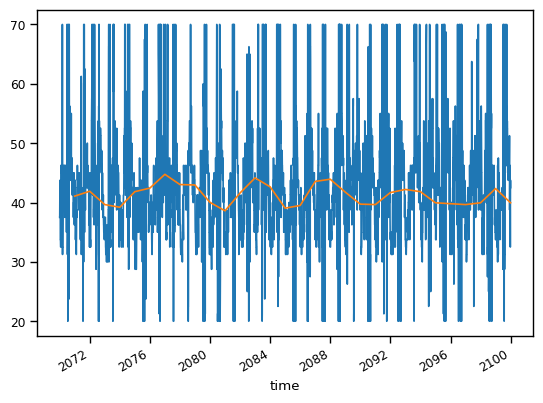

In [20]:
all_df_npac_future_dataset['Woollings et al. 2010']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()
all_df_npac_future_dataset['Bracegirdle et al. 2018']['HadGEM3-GC31-LL_r1i1p1f3'].dropna().plot()

In [21]:
len(all_df_npac_future_dataset['Woollings et al. 2010'].columns), len(all_df_npac_future_dataset['Barnes & Simpson 2017'].columns)

(96, 96)

#### view ensembles

In [22]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_future_dataset['Woollings et al. 2010'].columns])

Counter({'CanESM5': 20,
         'MIROC-ES2L': 10,
         'MPI-ESM1-2-LR': 9,
         'UKESM1-0-LL': 7,
         'CNRM-CM6-1': 6,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'IPSL-CM6A-LR': 3,
         'KACE-1-0-G': 3,
         'MIROC6': 3,
         'CESM2-WACCM': 3,
         'CNRM-ESM2-1': 2,
         'NESM3': 2,
         'ACCESS-ESM1-5': 2,
         'CMCC-ESM2': 1,
         'EC-Earth3-Veg-LR': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'EC-Earth3': 1,
         'MRI-ESM2-0': 1,
         'MPI-ESM1-2-HR': 1,
         'ACCESS-CM2': 1,
         'TaiESM1': 1,
         'EC-Earth3-CC': 1,
         'BCC-CSM2-MR': 1,
         'CMCC-CM2-SR5': 1,
         'INM-CM4-8': 1,
         'INM-CM5-0': 1,
         'FGOALS-g3': 1,
         'EC-Earth3-Veg': 1,
         'AWI-CM-1-1-MR': 1,
         'GFDL-CM4': 1})

In [23]:
# sorted(all_df_npac_future_dataset['Woollings et al. 2010'].columns, key=lambda row: row.split('_')[0])

# Load CMIP6 Historical

In [24]:
HIST_START_DATE = "1985-01-01"
HIST_END_DATE = "2015-12-31"
PERIOD_NUMBER_OF_DAYS = (pd.to_datetime(HIST_END_DATE) - pd.to_datetime(HIST_START_DATE)).days
MISSING_NUM_DAYS_THRESHOLD = 0.05 ## only allow for up to 5% less duration in data 

In [25]:
CMIP6_Historical_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_Historical_NPAC runs/outputs/ua_day*"

In [26]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Zappa et al. 2018", "Kerr et al. 2020"] #, "Barnes & Polvani 2015"
COLS_TO_REMOVE = ["10_day_average", "plev"]

region = "North Pacific"

In [27]:
print(region, len(glob.glob(CMIP6_Historical_dir + region + "*")))

North Pacific 1483


In [28]:
%%time
## takes ~65 seconds on Intel i7-10750 

time_ranges = []
failed_data_paths = []
data_paths_not_enough_days = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_Historical_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    current_data_period_in_days = (pd.to_datetime(last_time) - pd.to_datetime(first_time)).days
    ## check there is enough days
    if (PERIOD_NUMBER_OF_DAYS * MISSING_NUM_DAYS_THRESHOLD) < current_data_period_in_days:
        time_ranges.append(str(first_time)+'to'+str(last_time))
    else:
        data_paths_not_enough_days.append(file_path)

CPU times: user 54.6 s, sys: 132 ms, total: 54.8 s
Wall time: 54.8 s


In [29]:
collections.Counter(time_ranges)

Counter({'1950-01-01to2014-12-31': 953,
         '1950-01-01to2014-12-30': 189,
         '1950-01-01to2015-01-01': 84,
         '1950-01-01to2014-12-27': 49,
         '1950-01-01to2014-12-21': 27,
         '1950-01-02to2014-12-31': 7,
         '1950-01-01to2015-12-31': 7,
         '1950-01-02to2014-12-28': 1,
         '1950-01-01to2015-12-22': 1})

In [30]:
len(data_paths_not_enough_days)

0

In [31]:
## check all failures are bracegirdle (because this is an annual metric)
all(['Bracegirdle et al. 2018' in fn for fn in failed_data_paths]), len(failed_data_paths)

(True, 165)

In [32]:
%%time
## takes ~35 seconds on Intel i7-10750 
all_df_npac_hist_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                                           ignored_data_paths=[])
        continue
    all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"),
                                                                       ignored_data_paths=data_paths_not_enough_days)


CPU times: user 54.6 s, sys: 168 ms, total: 54.7 s
Wall time: 54.7 s


In [33]:
all_df_npac_hist_dataset['Woollings et al. 2010'].columns

Index(['ACCESS-CM2_r1i1p1f1', 'ACCESS-ESM1-5_r32i1p1f1',
       'IPSL-CM6A-LR_r2i1p1f1', 'MIROC-ES2L_r5i1p1f2', 'CNRM-CM6-1_r8i1p1f2',
       'CESM2_r5i1p1f1', 'CNRM-CM6-1_r4i1p1f2', 'BCC-CSM2-MR_r3i1p1f1',
       'HadGEM3-GC31-MM_r1i1p1f3', 'MRI-ESM2-0_r5i1p1f1',
       ...
       'GFDL-CM4_r1i1p1f1', 'CanESM5_r1i1p2f1', 'UKESM1-0-LL_r17i1p1f2',
       'CanESM5_r8i1p2f1', 'ACCESS-ESM1-5_r21i1p1f1',
       'ACCESS-ESM1-5_r17i1p1f1', 'IPSL-CM6A-LR_r5i1p1f1',
       'INM-CM4-8_r1i1p1f1', 'IPSL-CM6A-LR_r6i1p1f1', 'UKESM1-0-LL_r15i1p1f2'],
      dtype='object', length=164)

In [34]:
set(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns).difference(set(all_df_npac_hist_dataset['Woollings et al. 2010'].columns))

{'IITM-ESM_r1i1p1f1'}

In [35]:
%%time
## takes ~600 milliseconds on Intel i7-10750 
## rerun above 2 cell if you have a problem with Bracegirlde et al. 2018
START_YEAR = HIST_START_DATE[:4] # "1950"
END_YEAR = HIST_END_DATE[:4] # "2015"
FREQ = 'd'
for metric in metric_names:
    # print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric].index = pd.date_range(start="1950", freq="y", periods=len(all_df_npac_hist_dataset[metric])) # NOTE: START YEAR HARD CODED
        all_df_npac_hist_dataset[metric].index = all_df_npac_hist_dataset[metric].index.rename('time')
    all_df_npac_hist_dataset[metric].index = pd.to_datetime(all_df_npac_hist_dataset[metric].index, errors='coerce')
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric][START_YEAR: END_YEAR]
    if 'IITM-ESM_r1i1p1f1' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('IITM-ESM_r1i1p1f1', axis=1)
        print('removed IITM-ESM_r1i1p1f1')

removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
removed IITM-ESM_r1i1p1f1
CPU times: user 518 ms, sys: 132 ms, total: 650 ms
Wall time: 648 ms


In [36]:
len(all_df_npac_hist_dataset['Woollings et al. 2010'].columns), len(all_df_npac_hist_dataset['Barnes & Simpson 2017'].columns)

(164, 164)

In [37]:
collections.Counter([row.split('_r')[0] for row in all_df_npac_hist_dataset['Woollings et al. 2010'].columns])

Counter({'ACCESS-ESM1-5': 37,
         'CanESM5': 19,
         'UKESM1-0-LL': 17,
         'CNRM-CM6-1': 10,
         'IPSL-CM6A-LR': 9,
         'CESM2': 8,
         'MIROC-ES2L': 7,
         'MRI-ESM2-0': 5,
         'CNRM-ESM2-1': 5,
         'HadGEM3-GC31-LL': 5,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'BCC-ESM1': 3,
         'BCC-CSM2-MR': 2,
         'GISS-E2-1-G': 2,
         'ACCESS-CM2': 1,
         'EC-Earth3-AerChem': 1,
         'TaiESM1': 1,
         'FGOALS-g3': 1,
         'MPI-ESM-1-2-HAM': 1,
         'KACE-1-0-G': 1,
         'CMCC-ESM2': 1,
         'MPI-ESM1-2-HR': 1,
         'INM-CM5-0': 1,
         'NorESM2-LM': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-CM2-HR4': 1,
         'MPI-ESM1-2-LR': 1,
         'EC-Earth3': 1,
         'IPSL-CM5A2-INCA': 1,
         'MIROC6': 1,
         'CNRM-CM6-1-HR': 1,
         'CESM2-FV2': 1,
         'AWI-ESM-1-1-LR': 1,
         'NorESM2-MM': 1,
         'FGOALS-f3-L': 1,
         'IPSL-CM6A-LR-INCA

## Load Reanalysis

In [38]:
REAN_START_DATE = "1980-01-01"
REAN_END_DATE = "2022-12-31"
REAN_START_YEAR = REAN_START_DATE[:4]
REAN_END_YEAR = REAN_END_DATE[:4]

In [39]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Dev/Research Projects/uncertainty-in-npac-jet-shift/reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Dev/Research Projects/uncertainty-in-npac-jet-shift/reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['GrisePolvani2014_NorthPacific'] = pd.read_csv('/home/thomaskeel/Dev/Research Projects/uncertainty-in-npac-jet-shift/reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2014 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Dev/Research Projects/uncertainty-in-npac-jet-shift/reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[24:]##HARDCODED as starts at 1959
era_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Dev/Research Projects/uncertainty-in-npac-jet-shift/reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Dev/Research Projects/uncertainty-in-npac-jet-shift/reanalysis_jet_latitude_data/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [40]:
jra55_npac_day_dict = {}

jra55_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['GrisePolvani2014_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# jra55_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')[:-1] ##HARDCODED as ends at 2023
jra55_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
jra55_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [41]:
merra2_npac_day_dict = {}

merra2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['GrisePolvani2014_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# merra2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
merra2_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
merra2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [42]:
ncepdoe2_npac_day_dict = {}

ncepdoe2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['GrisePolvani2014_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
# ncepdoe2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
ncepdoe2_npac_day_dict['Zappa2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Zappa et al. 2018 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]
ncepdoe2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[REAN_START_YEAR: REAN_END_YEAR]


In [43]:
## Check length of Bracegirlde data
len(era_npac_day_dict['Bracegirdle2018_NorthPacific']), len(jra55_npac_day_dict['Bracegirdle2018_NorthPacific']), len(merra2_npac_day_dict['Bracegirdle2018_NorthPacific']), len(ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'])

(40, 43, 43, 43)

# Calculate Jet latitude mean and trends...

In [44]:
### required functions for calculating gradient/trend and formatting data
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

def get_year_gradient_of_trend(data, jet_lat_name='jet_lat', proportion_threshold_for_missing_data=4):
    """
        TODO: fix ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
    """
    try:
        cdata = data.dropna()
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except ValueError as ve:
        print(ve)
        pass
    try:
        assert float(data.isnull().sum(axis=0)) < (len(data)/proportion_threshold_for_missing_data)
        data = data.fillna(data.mean())
        lin_reg_line = get_linear_reg_slope(data, jet_lat_name)
        year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
        return year_gradient
    except AssertionError as ae:
        print(f"{data.name}failed. {int(data.isnull().sum(axis=0))} out of {len(data)} data points missing")
        return np.nan
    
def format_dict_to_dataframe(jet_lat_dict, unique_col_name):
    jet_lat_df = pd.DataFrame(jet_lat_dict)
    jet_lat_df = jet_lat_df.stack().reset_index()
    jet_lat_df.columns = ["Metric", "Dataset", unique_col_name]
    ## rename metric name to formatted version
    jet_lat_df['Metric'] = jet_lat_df.Metric.apply(lambda row: METRIC_LABEL_RENAMER[row])
    ## include decade trend 
    if 'trend' in unique_col_name.lower():
        jet_lat_df[unique_col_name+'_decade'] = jet_lat_df[unique_col_name]*10
    return jet_lat_df

## ... for reanalysis

In [45]:
%%time
## takes ~28 seconds on Intel i7-10750 
reanalysis_data = [era_npac_day_dict, jra55_npac_day_dict, merra2_npac_day_dict, ncepdoe2_npac_day_dict]
reanalysis_names = ["ERA-5", "JRA-55", "MERRA-2", "NCEP/DOE II"]
djf_jet_lat_mean_dict = {}
mam_jet_lat_mean_dict = {}
jja_jet_lat_mean_dict = {}
son_jet_lat_mean_dict = {}
djf_jet_lat_trend_dict = {}
mam_jet_lat_trend_dict = {}
jja_jet_lat_trend_dict = {}
son_jet_lat_trend_dict = {}
for ind, reanalysis_set in enumerate(reanalysis_data):
    reanalysis_name = reanalysis_names[ind]
    djf_jet_lat_mean_dict[reanalysis_name] = {}
    mam_jet_lat_mean_dict[reanalysis_name] = {}
    jja_jet_lat_mean_dict[reanalysis_name] = {}
    son_jet_lat_mean_dict[reanalysis_name] = {}
    djf_jet_lat_trend_dict[reanalysis_name] = {}
    mam_jet_lat_trend_dict[reanalysis_name] = {}
    jja_jet_lat_trend_dict[reanalysis_name] = {}
    son_jet_lat_trend_dict[reanalysis_name] = {}
    print(reanalysis_name)
    for metric in METRIC_DATA_NAMES:
        if metric == "Bracegirdle2018_NorthPacific":
            ## ignore because only calculated by annual scale
            continue
        else:
            reanalysis_set[metric].index = pd.to_datetime(reanalysis_set[metric].index)
            djf_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])]['jet_lat'].mean())
            mam_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])]['jet_lat'].mean())
            jja_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])]['jet_lat'].mean())
            son_jet_lat_mean_dict[reanalysis_name][metric] = float(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])]['jet_lat'].mean())
   
            djf_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([12, 1, 2])])
            mam_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([3, 4, 5])])
            jja_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([6, 7, 8])])
            son_jet_lat_trend_dict[reanalysis_name][metric] = get_year_gradient_of_trend(reanalysis_set[metric][reanalysis_set[metric].index.month.isin([9, 10, 11])])

ERA-5
JRA-55
MERRA-2
NCEP/DOE II
CPU times: user 27.2 s, sys: 4.1 ms, total: 27.2 s
Wall time: 27.2 s


In [46]:
djf_jet_lat_mean_df = format_dict_to_dataframe(djf_jet_lat_mean_dict, "DJF mean")
djf_jet_lat_trend_df = format_dict_to_dataframe(djf_jet_lat_trend_dict, "DJF Trend")

mam_jet_lat_mean_df = format_dict_to_dataframe(mam_jet_lat_mean_dict, "MAM mean")
mam_jet_lat_trend_df = format_dict_to_dataframe(mam_jet_lat_trend_dict, "MAM Trend")

jja_jet_lat_mean_df = format_dict_to_dataframe(jja_jet_lat_mean_dict, "JJA mean")
jja_jet_lat_trend_df = format_dict_to_dataframe(jja_jet_lat_trend_dict, "JJA Trend")

son_jet_lat_mean_df = format_dict_to_dataframe(son_jet_lat_mean_dict, "SON mean")
son_jet_lat_trend_df = format_dict_to_dataframe(son_jet_lat_trend_dict, "SON Trend")

In [47]:
## merge all
allseasons_jet_lat_mean_df = djf_jet_lat_mean_df.merge(mam_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(jja_jet_lat_mean_df)
allseasons_jet_lat_mean_df = allseasons_jet_lat_mean_df.merge(son_jet_lat_mean_df)

allseasons_jet_lat_trend_df = djf_jet_lat_trend_df.merge(mam_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(jja_jet_lat_trend_df)
allseasons_jet_lat_trend_df = allseasons_jet_lat_trend_df.merge(son_jet_lat_trend_df)

all_seasons_rean_jet_lat_mean_and_trend_df = allseasons_jet_lat_mean_df.merge(allseasons_jet_lat_trend_df)

In [48]:
all_seasons_rean_jet_lat_mean_and_trend_df.head()

,Metric,Dataset,DJF mean,MAM mean,JJA mean,SON mean,DJF Trend,DJF Trend_decade,MAM Trend,MAM Trend_decade,JJA Trend,JJA Trend_decade,SON Trend,SON Trend_decade
0,Woollings et al. 2010,ERA-5,38.416556,41.383023,46.510934,45.741104,0.084118,0.841182,0.027162,0.271624,0.042990,0.429904,-0.012295,-0.122950
1,Woollings et al. 2010,JRA-55,38.411569,41.420807,46.809330,45.812075,0.076927,0.769266,0.025799,0.257988,0.063805,0.638047,0.001078,0.010777
2,Woollings et al. 2010,MERRA-2,38.401064,41.398680,46.062699,45.692318,0.068468,0.684678,0.007373,0.073727,0.036818,0.368179,0.000604,0.006043
3,Woollings et al. 2010,NCEP/DOE II,38.296543,41.183359,46.412396,45.794741,0.072824,0.728244,0.010188,0.101878,0.022320,0.223199,-0.007454,-0.074542
4,Barnes & Polvani 2013,ERA-5,38.548350,41.464314,46.260380,45.786321,0.088743,0.887431,0.026058,0.260579,0.039101,0.391015,-0.013391,-0.133915


## .. for CMIP6 Historical

In [49]:
%%time
## takes ~16 minutes on Intel i7-10750 

hist_djf_jet_lat_mean_dict = {}
hist_mam_jet_lat_mean_dict = {}
hist_jja_jet_lat_mean_dict = {}
hist_son_jet_lat_mean_dict = {}

hist_djf_jet_lat_trend_dict = {}
hist_mam_jet_lat_trend_dict = {}
hist_jja_jet_lat_trend_dict = {}
hist_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    hist_djf_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].mean()
    hist_mam_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].mean()
    hist_jja_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].mean()
    hist_son_jet_lat_mean_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    hist_djf_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_mam_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_jja_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    hist_son_jet_lat_trend_dict[metric] = all_df_npac_hist_dataset[metric][all_df_npac_hist_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010
Barnes & Polvani 2013
Barnes & Simpson 2017
Grise & Polvani 2017
Bracegirdle et al. 2018
Zappa et al. 2018
Kerr et al. 2020
CPU times: user 13min 13s, sys: 95.9 ms, total: 13min 13s
Wall time: 13min 13s


In [50]:
hist_djf_jet_lat_trend_dict['Woollings et al. 2010']

ACCESS-CM2_r1i1p1f1       -0.022090
ACCESS-ESM1-5_r32i1p1f1    0.041596
IPSL-CM6A-LR_r2i1p1f1     -0.064092
MIROC-ES2L_r5i1p1f2        0.012702
CNRM-CM6-1_r8i1p1f2       -0.002326
                             ...   
ACCESS-ESM1-5_r17i1p1f1   -0.106107
IPSL-CM6A-LR_r5i1p1f1      0.015359
INM-CM4-8_r1i1p1f1        -0.011284
IPSL-CM6A-LR_r6i1p1f1      0.003912
UKESM1-0-LL_r15i1p1f2      0.120264
Length: 164, dtype: float64

In [51]:
hist_djf_jet_lat_mean_df = pd.concat(hist_djf_jet_lat_mean_dict, axis=1)
hist_mam_jet_lat_mean_df = pd.concat(hist_mam_jet_lat_mean_dict, axis=1)
hist_jja_jet_lat_mean_df = pd.concat(hist_jja_jet_lat_mean_dict, axis=1)
hist_son_jet_lat_mean_df = pd.concat(hist_son_jet_lat_mean_dict, axis=1)

hist_djf_jet_lat_trend_df = pd.concat(hist_djf_jet_lat_trend_dict, axis=1)
hist_mam_jet_lat_trend_df = pd.concat(hist_mam_jet_lat_trend_dict, axis=1)
hist_jja_jet_lat_trend_df = pd.concat(hist_jja_jet_lat_trend_dict, axis=1)
hist_son_jet_lat_trend_df = pd.concat(hist_son_jet_lat_trend_dict, axis=1)

In [52]:
hist_djf_jet_lat_trend_df.head()

,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
ACCESS-CM2_r1i1p1f1,-0.022090,-0.023670,0.002520,0.000358,-0.018019,-0.009733
ACCESS-ESM1-5_r32i1p1f1,0.041596,0.042469,0.063992,0.020491,0.014102,0.008166
IPSL-CM6A-LR_r2i1p1f1,-0.064092,-0.062280,-0.055824,-0.074649,-0.045927,-0.046527
MIROC-ES2L_r5i1p1f2,0.012702,0.010964,0.004960,-0.022321,-0.010354,0.018263
CNRM-CM6-1_r8i1p1f2,-0.002326,-0.009497,0.002487,-0.002897,-0.008174,-0.000337


## .. for CMIP6 SSP5-8.5

In [53]:
%%time
## takes ~4 minutes on Intel i7-10750 
ssp585_djf_jet_lat_mean_dict = {}
ssp585_mam_jet_lat_mean_dict = {}
ssp585_jja_jet_lat_mean_dict = {}
ssp585_son_jet_lat_mean_dict = {}

ssp585_djf_jet_lat_trend_dict = {}
ssp585_mam_jet_lat_trend_dict = {}
ssp585_jja_jet_lat_trend_dict = {}
ssp585_son_jet_lat_trend_dict = {}

for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        ## ignore because only calculated by annual scale
        continue
    ssp585_djf_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].mean()
    ssp585_mam_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].mean()
    ssp585_jja_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].mean()
    ssp585_son_jet_lat_mean_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].mean()
    
    ssp585_djf_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([12, 1, 2])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_mam_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([3, 4, 5])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_jja_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([6, 7, 8])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)
    ssp585_son_jet_lat_trend_dict[metric] = all_df_npac_future_dataset[metric][all_df_npac_future_dataset[metric].index.month.isin([9, 10, 11])].apply(lambda col: get_year_gradient_of_trend(pd.DataFrame(col), col.name), axis=0)

Woollings et al. 2010


/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Barnes & Polvani 2013


/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Barnes & Simpson 2017


/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Grise & Polvani 2017


/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Bracegirdle et al. 2018
Zappa et al. 2018


/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


Kerr et al. 2020


/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])
/tmp/ipykernel_29558/3422997013.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  year_gradient = (lin_reg_line['reg_line'][-1] - lin_reg_line['reg_line'][0]) / (lin_reg_line.index.year[-1]  - lin_reg_line.index.year[0])


CPU times: user 6min 51s, sys: 15.3 ms, total: 6min 51s
Wall time: 6min 51s


In [54]:
ssp585_djf_jet_lat_mean_df = pd.concat(ssp585_djf_jet_lat_mean_dict, axis=1)
ssp585_mam_jet_lat_mean_df = pd.concat(ssp585_mam_jet_lat_mean_dict, axis=1)
ssp585_jja_jet_lat_mean_df = pd.concat(ssp585_jja_jet_lat_mean_dict, axis=1)
ssp585_son_jet_lat_mean_df = pd.concat(ssp585_son_jet_lat_mean_dict, axis=1)

ssp585_djf_jet_lat_trend_df = pd.concat(ssp585_djf_jet_lat_trend_dict, axis=1)
ssp585_mam_jet_lat_trend_df = pd.concat(ssp585_mam_jet_lat_trend_dict, axis=1)
ssp585_jja_jet_lat_trend_df = pd.concat(ssp585_jja_jet_lat_trend_dict, axis=1)
ssp585_son_jet_lat_trend_df = pd.concat(ssp585_son_jet_lat_trend_dict, axis=1)

In [55]:
ssp585_djf_jet_lat_trend_df.head()

,Woollings et al. 2010,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2017,Zappa et al. 2018,Kerr et al. 2020
CanESM5_r3i1p1f1,-0.004942,-0.006274,0.011759,0.006236,-0.001753,0.016096
CMCC-ESM2_r1i1p1f1,0.101355,0.110416,0.119541,0.096225,0.067462,0.078099
CanESM5_r10i1p2f1,0.082631,0.084627,0.144880,0.038451,0.052307,0.035471
UKESM1-0-LL_r14i1p1f2,-0.033018,-0.030140,-0.043708,-0.017527,-0.006941,-0.006313
CanESM5_r5i1p2f1,0.107703,0.096728,0.136140,0.110759,0.086455,0.071234


### Rename Grise Polvani 2017 to 2014

In [56]:
hist_djf_jet_lat_mean_df['Grise & Polvani 2014'] = hist_djf_jet_lat_mean_df['Grise & Polvani 2017']
hist_djf_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_djf_jet_lat_trend_df['Grise & Polvani 2014'] = hist_djf_jet_lat_trend_df['Grise & Polvani 2017']
hist_djf_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_mam_jet_lat_mean_df['Grise & Polvani 2014'] = hist_mam_jet_lat_mean_df['Grise & Polvani 2017']
hist_mam_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_mam_jet_lat_trend_df['Grise & Polvani 2014'] = hist_mam_jet_lat_trend_df['Grise & Polvani 2017']
hist_mam_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_jja_jet_lat_mean_df['Grise & Polvani 2014'] = hist_jja_jet_lat_mean_df['Grise & Polvani 2017']
hist_jja_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_jja_jet_lat_trend_df['Grise & Polvani 2014'] = hist_jja_jet_lat_trend_df['Grise & Polvani 2017']
hist_jja_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_son_jet_lat_mean_df['Grise & Polvani 2014'] = hist_son_jet_lat_mean_df['Grise & Polvani 2017']
hist_son_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

hist_son_jet_lat_trend_df['Grise & Polvani 2014'] = hist_son_jet_lat_trend_df['Grise & Polvani 2017']
hist_son_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

In [57]:
ssp585_djf_jet_lat_mean_df['Grise & Polvani 2014'] = ssp585_djf_jet_lat_mean_df['Grise & Polvani 2017']
ssp585_djf_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_djf_jet_lat_trend_df['Grise & Polvani 2014'] = ssp585_djf_jet_lat_trend_df['Grise & Polvani 2017']
ssp585_djf_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_mam_jet_lat_mean_df['Grise & Polvani 2014'] = ssp585_mam_jet_lat_mean_df['Grise & Polvani 2017']
ssp585_mam_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_mam_jet_lat_trend_df['Grise & Polvani 2014'] = ssp585_mam_jet_lat_trend_df['Grise & Polvani 2017']
ssp585_mam_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_jja_jet_lat_mean_df['Grise & Polvani 2014'] = ssp585_jja_jet_lat_mean_df['Grise & Polvani 2017']
ssp585_jja_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_jja_jet_lat_trend_df['Grise & Polvani 2014'] = ssp585_jja_jet_lat_trend_df['Grise & Polvani 2017']
ssp585_jja_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_son_jet_lat_mean_df['Grise & Polvani 2014'] = ssp585_son_jet_lat_mean_df['Grise & Polvani 2017']
ssp585_son_jet_lat_mean_df.drop('Grise & Polvani 2017', axis=1, inplace=True)

ssp585_son_jet_lat_trend_df['Grise & Polvani 2014'] = ssp585_son_jet_lat_trend_df['Grise & Polvani 2017']
ssp585_son_jet_lat_trend_df.drop('Grise & Polvani 2017', axis=1, inplace=True)


# Calculate Mann Whitney U shift

In [58]:
model_names_for_mwu_shift = set(hist_djf_jet_lat_mean_df.index).intersection(set(ssp585_djf_jet_lat_mean_df.index))

In [59]:
# workaround due to 
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Simpson 2017",\
                "Grise & Polvani 2017", "Zappa et al. 2018", "Kerr et al. 2020"]

<Axes: xlabel='HadGEM3-GC31-MM_r3i1p1f3', ylabel='Density'>

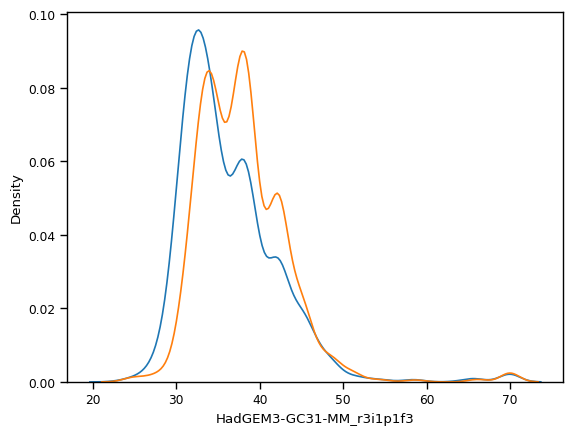

In [60]:
cmip_model_to_look_at = 'HadGEM3-GC31-MM_r3i1p1f3'# 'CNRM-ESM2-1_r4i1p1f2'#' 'MPI-ESM1-2-LR_r1i1p1f1'
sns.kdeplot(all_df_npac_hist_dataset['Woollings et al. 2010'][cmip_model_to_look_at][all_df_npac_hist_dataset['Woollings et al. 2010'][cmip_model_to_look_at].index.month.isin([12, 1, 2])])
sns.kdeplot(all_df_npac_future_dataset['Woollings et al. 2010'][cmip_model_to_look_at][all_df_npac_future_dataset['Woollings et al. 2010'][cmip_model_to_look_at].index.month.isin([12, 1, 2])])

In [61]:
%%time
# Takes 7 seconds
cmip6_djf_jet_lat_shift_sig = {}
cmip6_mam_jet_lat_shift_sig = {}
cmip6_jja_jet_lat_shift_sig = {}
cmip6_son_jet_lat_shift_sig = {}
for metric in metric_names:
    model_mannwhitney_pvals_djf = {}
    model_mannwhitney_pvals_mam = {}
    model_mannwhitney_pvals_jja = {}
    model_mannwhitney_pvals_son = {}
    for model_name in model_names_for_mwu_shift:
        mannwhit_djf = scipy.stats.mannwhitneyu(all_df_npac_hist_dataset[metric][model_name][all_df_npac_hist_dataset[metric][model_name].index.month.isin([12, 1, 2])].dropna(), all_df_npac_future_dataset[metric][model_name][all_df_npac_future_dataset[metric][model_name].index.month.isin([12, 1, 2])].dropna()).pvalue
        mannwhit_mam = scipy.stats.mannwhitneyu(all_df_npac_hist_dataset[metric][model_name][all_df_npac_hist_dataset[metric][model_name].index.month.isin([3, 4, 5])].dropna(), all_df_npac_future_dataset[metric][model_name][all_df_npac_future_dataset[metric][model_name].index.month.isin([3, 4, 5])].dropna()).pvalue
        mannwhit_jja = scipy.stats.mannwhitneyu(all_df_npac_hist_dataset[metric][model_name][all_df_npac_hist_dataset[metric][model_name].index.month.isin([6, 7, 8])].dropna(), all_df_npac_future_dataset[metric][model_name][all_df_npac_future_dataset[metric][model_name].index.month.isin([6, 7, 8])].dropna()).pvalue
        mannwhit_son = scipy.stats.mannwhitneyu(all_df_npac_hist_dataset[metric][model_name][all_df_npac_hist_dataset[metric][model_name].index.month.isin([9, 10, 11])].dropna(), all_df_npac_future_dataset[metric][model_name][all_df_npac_future_dataset[metric][model_name].index.month.isin([9, 10, 11])].dropna()).pvalue
        model_mannwhitney_pvals_djf[model_name] = mannwhit_djf
        model_mannwhitney_pvals_mam[model_name] = mannwhit_mam
        model_mannwhitney_pvals_jja[model_name] = mannwhit_jja
        model_mannwhitney_pvals_son[model_name] = mannwhit_son
    cmip6_djf_jet_lat_shift_sig[metric] = pd.Series(model_mannwhitney_pvals_djf)
    cmip6_mam_jet_lat_shift_sig[metric] = pd.Series(model_mannwhitney_pvals_mam)
    cmip6_jja_jet_lat_shift_sig[metric] = pd.Series(model_mannwhitney_pvals_jja)
    cmip6_son_jet_lat_shift_sig[metric] = pd.Series(model_mannwhitney_pvals_son)

CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.4 s


In [62]:
cmip6_djf_jet_lat_shift_sig_df = pd.concat(cmip6_djf_jet_lat_shift_sig, axis=1)
cmip6_mam_jet_lat_shift_sig_df = pd.concat(cmip6_mam_jet_lat_shift_sig, axis=1)
cmip6_jja_jet_lat_shift_sig_df = pd.concat(cmip6_jja_jet_lat_shift_sig, axis=1)
cmip6_son_jet_lat_shift_sig_df = pd.concat(cmip6_son_jet_lat_shift_sig, axis=1)

In [63]:
(cmip6_djf_jet_lat_shift_sig_df < 0.05).sum() # out of 75

Woollings et al. 2010    68
Barnes & Polvani 2013    68
Barnes & Simpson 2017    50
Grise & Polvani 2017     64
Zappa et al. 2018        68
Kerr et al. 2020         63
dtype: int64

In [64]:
(cmip6_son_jet_lat_shift_sig_df < 0.05).sum() # out of 75

Woollings et al. 2010    69
Barnes & Polvani 2013    69
Barnes & Simpson 2017    64
Grise & Polvani 2017     70
Zappa et al. 2018        70
Kerr et al. 2020         64
dtype: int64

# Combine data

#### sort cols

In [65]:
hist_djf_jet_lat_mean_df = hist_djf_jet_lat_mean_df[sorted(hist_djf_jet_lat_mean_df.columns, key=lambda col: col[-4:])]
hist_mam_jet_lat_mean_df = hist_mam_jet_lat_mean_df[sorted(hist_mam_jet_lat_mean_df.columns, key=lambda col: col[-4:])]
hist_jja_jet_lat_mean_df = hist_jja_jet_lat_mean_df[sorted(hist_jja_jet_lat_mean_df.columns, key=lambda col: col[-4:])]
hist_son_jet_lat_mean_df = hist_son_jet_lat_mean_df[sorted(hist_son_jet_lat_mean_df.columns, key=lambda col: col[-4:])]

hist_djf_jet_lat_trend_df = hist_djf_jet_lat_trend_df[sorted(hist_djf_jet_lat_trend_df.columns, key=lambda col: col[-4:])]
hist_mam_jet_lat_trend_df = hist_mam_jet_lat_trend_df[sorted(hist_mam_jet_lat_trend_df.columns, key=lambda col: col[-4:])]
hist_jja_jet_lat_trend_df = hist_jja_jet_lat_trend_df[sorted(hist_jja_jet_lat_trend_df.columns, key=lambda col: col[-4:])]
hist_son_jet_lat_trend_df = hist_son_jet_lat_trend_df[sorted(hist_son_jet_lat_trend_df.columns, key=lambda col: col[-4:])]

ssp585_djf_jet_lat_mean_df = ssp585_djf_jet_lat_mean_df[sorted(ssp585_djf_jet_lat_mean_df.columns, key=lambda col: col[-4:])]
ssp585_mam_jet_lat_mean_df = ssp585_mam_jet_lat_mean_df[sorted(ssp585_mam_jet_lat_mean_df.columns, key=lambda col: col[-4:])]
ssp585_jja_jet_lat_mean_df = ssp585_jja_jet_lat_mean_df[sorted(ssp585_jja_jet_lat_mean_df.columns, key=lambda col: col[-4:])]
ssp585_son_jet_lat_mean_df = ssp585_son_jet_lat_mean_df[sorted(ssp585_son_jet_lat_mean_df.columns, key=lambda col: col[-4:])]

ssp585_djf_jet_lat_trend_df = ssp585_djf_jet_lat_trend_df[sorted(ssp585_djf_jet_lat_trend_df.columns, key=lambda col: col[-4:])]
ssp585_mam_jet_lat_trend_df = ssp585_mam_jet_lat_trend_df[sorted(ssp585_mam_jet_lat_trend_df.columns, key=lambda col: col[-4:])]
ssp585_jja_jet_lat_trend_df = ssp585_jja_jet_lat_trend_df[sorted(ssp585_jja_jet_lat_trend_df.columns, key=lambda col: col[-4:])]
ssp585_son_jet_lat_trend_df = ssp585_son_jet_lat_trend_df[sorted(ssp585_son_jet_lat_trend_df.columns, key=lambda col: col[-4:])]


In [66]:
all_seasons_rean_jet_lat_mean_and_trend_df = all_seasons_rean_jet_lat_mean_and_trend_df.loc[~(all_seasons_rean_jet_lat_mean_and_trend_df.Metric == "Bracegirdle et al. 2018")]

In [67]:
djf_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='DJF mean')
djf_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='DJF Trend_decade')

# mam_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='MAM mean')
# mam_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='MAM Trend_decade')

# jja_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='JJA mean')
# jja_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='JJA Trend_decade')

son_all_rean_mean = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='SON mean')
son_all_rean_trend = all_seasons_rean_jet_lat_mean_and_trend_df.pivot(index='Dataset', columns='Metric', values='SON Trend_decade')

In [68]:
djf_all_rean_mean

Metric,Barnes & Polvani 2013,Barnes & Simpson 2017,Grise & Polvani 2014,Kerr et al. 2020,Woollings et al. 2010,Zappa et al. 2018
Dataset,,,,,,
ERA-5,38.548350,37.569737,39.275320,40.890976,38.416556,38.155137
JRA-55,38.483448,37.378289,39.184255,40.868328,38.411569,38.294532
MERRA-2,38.545687,37.627632,39.341559,41.368274,38.401064,38.332956
NCEP/DOE II,38.356249,37.348684,38.901179,40.398150,38.296543,38.201884


In [69]:
djf_all_rean_mean = djf_all_rean_mean[sorted(djf_all_rean_mean.columns, key=lambda x: x[-4:])]
djf_all_rean_trend = djf_all_rean_trend[sorted(djf_all_rean_trend.columns, key=lambda x: x[-4:])]

# mam_all_rean_mean = mam_all_rean_mean[sorted(mam_all_rean_mean.columns, key=lambda x: x[-4:])]
# mam_all_rean_trend = mam_all_rean_trend[sorted(mam_all_rean_trend.columns, key=lambda x: x[-4:])]

# jja_all_rean_mean = jja_all_rean_mean[sorted(jja_all_rean_mean.columns, key=lambda x: x[-4:])]
# jja_all_rean_trend = jja_all_rean_trend[sorted(jja_all_rean_trend.columns, key=lambda x: x[-4:])]

son_all_rean_mean = son_all_rean_mean[sorted(son_all_rean_mean.columns, key=lambda x: x[-4:])]
son_all_rean_trend = son_all_rean_trend[sorted(son_all_rean_trend.columns, key=lambda x: x[-4:])]

#### sort index by minimum difference from reanalysis mean across all metrics

In [70]:
sorted_index_by_minimum_error_from_reanalysis_mean_djf = abs(hist_djf_jet_lat_mean_df -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_djf = abs(hist_djf_jet_lat_trend_df -  djf_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_mam = abs(hist_mam_jet_lat_mean_df -  mam_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index
# sorted_index_by_minimum_error_from_reanalysis_trends_mam = abs(hist_mam_jet_lat_trend_df -  mam_all_rean_trend.mean())\
#                                                     .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_jja = abs(hist_jja_jet_lat_mean_df -  jja_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index
# sorted_index_by_minimum_error_from_reanalysis_trends_jja = abs(hist_jja_jet_lat_trend_df -  jja_all_rean_trend.mean())\
#                                                     .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_son = abs(hist_son_jet_lat_mean_df -  son_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index
sorted_index_by_minimum_error_from_reanalysis_trends_son = abs(hist_son_jet_lat_trend_df -  son_all_rean_trend.mean())\
                                                    .sum(axis=1).sort_values().index

In [71]:
hist_djf_jet_lat_mean_df = hist_djf_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_djf]
hist_djf_jet_lat_trend_df = hist_djf_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_djf]

# hist_mam_jet_lat_mean_df = hist_mam_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_mam]
# hist_mam_jet_lat_trend_df = hist_mam_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_mam]

# hist_jja_jet_lat_mean_df = hist_jja_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_jja]
# hist_jja_jet_lat_trend_df = hist_jja_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_jja]

hist_son_jet_lat_mean_df = hist_son_jet_lat_mean_df.loc[sorted_index_by_minimum_error_from_reanalysis_mean_son]
hist_son_jet_lat_trend_df = hist_son_jet_lat_trend_df.loc[sorted_index_by_minimum_error_from_reanalysis_trends_son]

#### join to reanalysis

In [72]:
djf_hist_and_rean_mean = pd.concat([djf_all_rean_mean, hist_djf_jet_lat_mean_df])
djf_hist_and_rean_trend = pd.concat([djf_all_rean_trend, hist_djf_jet_lat_trend_df])

# mam_hist_and_rean_mean = pd.concat([mam_all_rean_mean, hist_mam_jet_lat_mean_df])
# mam_hist_and_rean_trend = pd.concat([mam_all_rean_trend, hist_mam_jet_lat_trend_df])

# jja_hist_and_rean_mean = pd.concat([jja_all_rean_mean, hist_jja_jet_lat_mean_df])
# jja_hist_and_rean_trend = pd.concat([jja_all_rean_trend, hist_jja_jet_lat_trend_df])

son_hist_and_rean_mean = pd.concat([son_all_rean_mean, hist_son_jet_lat_mean_df])
son_hist_and_rean_trend = pd.concat([son_all_rean_trend, hist_son_jet_lat_trend_df])


### join to ssp585

In [73]:
djf_hist_rean_and_future_mean = pd.concat([djf_hist_and_rean_mean, ssp585_djf_jet_lat_mean_df], axis=1)
djf_hist_rean_and_future_trend = pd.concat([djf_hist_and_rean_trend, ssp585_djf_jet_lat_trend_df], axis=1)

# mam_hist_rean_and_future_mean = pd.concat([mam_hist_and_rean_mean, ssp585_mam_jet_lat_mean_df], axis=1)
# mam_hist_rean_and_future_trend = pd.concat([mam_hist_and_rean_trend, ssp585_mam_jet_lat_trend_df], axis=1)

# jja_hist_rean_and_future_mean = pd.concat([jja_hist_and_rean_mean, ssp585_jja_jet_lat_mean_df], axis=1)
# jja_hist_rean_and_future_trend = pd.concat([jja_hist_and_rean_trend, ssp585_jja_jet_lat_trend_df], axis=1)

son_hist_rean_and_future_mean = pd.concat([son_hist_and_rean_mean, ssp585_son_jet_lat_mean_df], axis=1)
son_hist_rean_and_future_trend = pd.concat([son_hist_and_rean_trend, ssp585_son_jet_lat_trend_df], axis=1)

In [74]:
djf_hist_and_rean_mean.index

Index(['ERA-5', 'JRA-55', 'MERRA-2', 'NCEP/DOE II', 'TaiESM1_r1i1p1f1',
       'CanESM5_r9i1p1f1', 'NorESM2-LM_r1i1p1f1', 'HadGEM3-GC31-LL_r5i1p1f3',
       'CESM2_r7i1p1f1', 'CESM2-WACCM_r2i1p1f1',
       ...
       'MRI-ESM2-0_r3i1p1f1', 'MRI-ESM2-0_r1i1p1f1', 'MIROC-ES2L_r3i1p1f2',
       'GISS-E2-1-G_r1i1p1f2', 'MIROC-ES2L_r6i1p1f2', 'MIROC-ES2L_r5i1p1f2',
       'MIROC-ES2L_r8i1p1f2', 'MIROC-ES2L_r1i1p1f2', 'MIROC-ES2L_r2i1p1f2',
       'INM-CM4-8_r1i1p1f1'],
      dtype='object', length=168)

<Axes: >

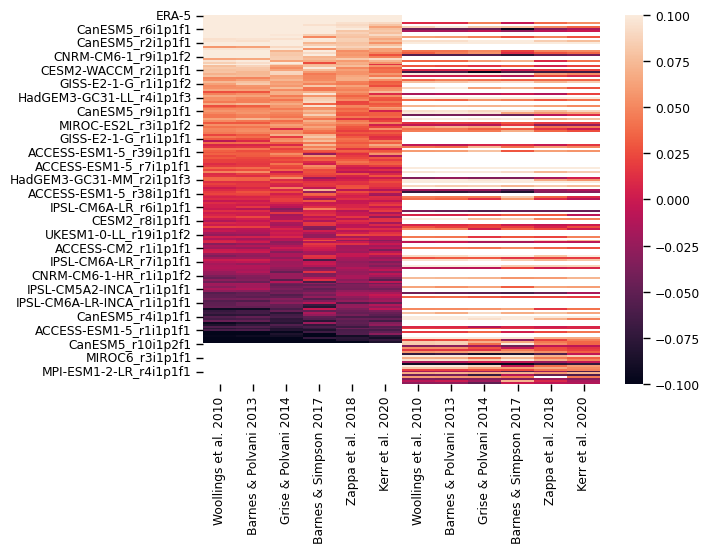

In [75]:
sns.heatmap(djf_hist_rean_and_future_trend)

## CMIP6 Future Difference instead of absolute 

In [76]:
for metric in METRIC_NAMES:
    if metric == "Bracegirdle et al. 2018":
        continue
    if metric == "Woollings et al. 2010":
        ## i.e. if first value init the overall dataframe
        metric_future_mean_diff_djf = pd.DataFrame(djf_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        metric_future_trend_diff_djf = pd.DataFrame(djf_hist_rean_and_future_trend[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_trend[metric].index, columns=[metric+"_diff"])
        
#         metric_future_mean_diff_mam = pd.DataFrame(mam_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
#                                           mam_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
#         metric_future_mean_diff_jja = pd.DataFrame(jja_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          # jja_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        metric_future_mean_diff_son = pd.DataFrame(son_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          son_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
        
        continue
    current_data_mean_djf = pd.DataFrame(djf_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
    
    current_data_trends_djf = pd.DataFrame(djf_hist_rean_and_future_trend[metric].diff(axis=1).values[::,1],\
                                          djf_hist_rean_and_future_trend[metric].index, columns=[metric+"_diff"])
    
    metric_future_mean_diff_djf = pd.concat([metric_future_mean_diff_djf, current_data_mean_djf], axis=1)
    metric_future_trend_diff_djf = pd.concat([metric_future_trend_diff_djf, current_data_trends_djf], axis=1)
    
#     current_data_mean_mam = pd.DataFrame(mam_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
#                                           mam_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
#     metric_future_mean_diff_mam = pd.concat([metric_future_mean_diff_mam, current_data_mean_mam], axis=1)

#     current_data_mean_jja = pd.DataFrame(jja_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
#                                           jja_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
#     metric_future_mean_diff_jja = pd.concat([metric_future_mean_diff_jja, current_data_mean_jja], axis=1)

    
    current_data_mean_son = pd.DataFrame(son_hist_rean_and_future_mean[metric].diff(axis=1).values[::,1],\
                                          son_hist_rean_and_future_mean[metric].index, columns=[metric+"_diff"])
    metric_future_mean_diff_son = pd.concat([metric_future_mean_diff_son, current_data_mean_son], axis=1)


In [77]:
mean_diff_data_djf = metric_future_mean_diff_djf.dropna(how='all')
# mean_diff_data_mam = metric_future_mean_diff_mam.dropna(how='all')
# mean_diff_data_jja = metric_future_mean_diff_jja.dropna(how='all')
mean_diff_data_son = metric_future_mean_diff_son.dropna(how='all')

<Axes: >

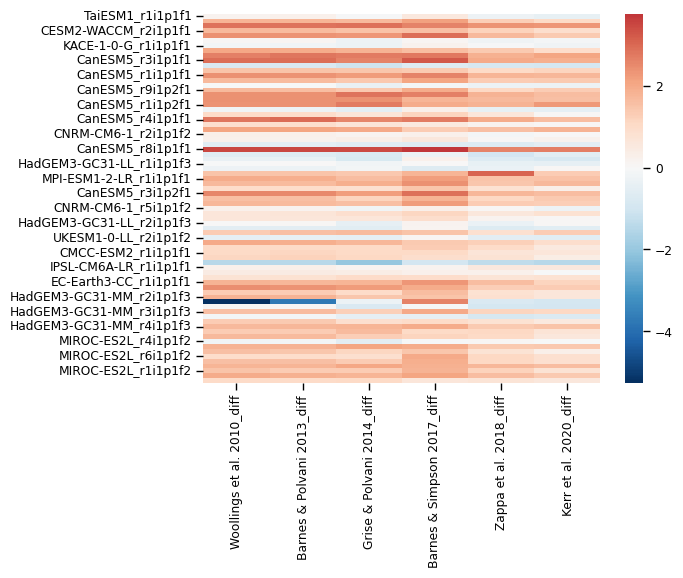

In [78]:
sns.heatmap(mean_diff_data_djf, center=0, cmap='RdBu_r')

In [79]:
# djf_hist_rean_and_future_mean.to_csv('outputs/djf_hist_rean_future_mean.csv')
# djf_hist_rean_and_future_trend.to_csv('outputs/djf_hist_rean_future_trend.csv')

# mam_hist_rean_and_future_mean.to_csv('outputs/mam_hist_rean_future_mean.csv')
# mam_hist_rean_and_future_trend.to_csv('outputs/mam_hist_rean_future_trend.csv')

# jja_hist_rean_and_future_mean.to_csv('outputs/jja_hist_rean_future_mean.csv')
# jja_hist_rean_and_future_trend.to_csv('outputs/jja_hist_rean_future_trend.csv')

# son_hist_rean_and_future_mean.to_csv('outputs/son_hist_rean_future_mean.csv')
# son_hist_rean_and_future_trend.to_csv('outputs/son_hist_rean_future_trend.csv')

In [80]:
# pd.read_csv('outputs/djf_hist_rean_future_mean.csv')

# Make Figure 4

In [81]:
djf_hist_and_future_mean_diffs = metric_future_mean_diff_djf[metric_future_mean_diff_djf.columns[-6:]].iloc[4:]
djf_hist_and_future_mean_diffs_w_mean = pd.concat([djf_hist_and_future_mean_diffs.mean(axis=1), djf_hist_and_future_mean_diffs], axis=1)
djf_hist_and_future_mean_diffs_w_mean.columns = ["mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Grise & Polvani 2014", "Barnes & Simpson 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
djf_hist_and_future_mean_diffs_w_mean = djf_hist_and_future_mean_diffs_w_mean.dropna() 


# mam_hist_and_future_mean_diffs = metric_future_mean_diff_mam[metric_future_mean_diff_mam.columns[-6:]].iloc[4:]
# mam_hist_and_future_mean_diffs_w_mean = pd.concat([mam_hist_and_future_mean_diffs.mean(axis=1), mam_hist_and_future_mean_diffs], axis=1)
# mam_hist_and_future_mean_diffs_w_mean.columns = ["mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
#                                                     "Barnes & Simpson 2017", "Grise & Polvani 2017",\
#                                                    "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
# mam_hist_and_future_mean_diffs_w_mean = mam_hist_and_future_mean_diffs_w_mean.dropna() 



# jja_hist_and_future_mean_diffs = metric_future_mean_diff_jja[metric_future_mean_diff_jja.columns[-6:]].iloc[4:]
# jja_hist_and_future_mean_diffs_w_mean = pd.concat([jja_hist_and_future_mean_diffs.mean(axis=1), jja_hist_and_future_mean_diffs], axis=1)
# jja_hist_and_future_mean_diffs_w_mean.columns = ["mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
#                                                     "Barnes & Simpson 2017", "Grise & Polvani 2017",\
#                                                    "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
# jja_hist_and_future_mean_diffs_w_mean = jja_hist_and_future_mean_diffs_w_mean.dropna() 



son_hist_and_future_mean_diffs = metric_future_mean_diff_son[metric_future_mean_diff_son.columns[-6:]].iloc[4:]
son_hist_and_future_mean_diffs_w_mean = pd.concat([son_hist_and_future_mean_diffs.mean(axis=1), son_hist_and_future_mean_diffs], axis=1)
son_hist_and_future_mean_diffs_w_mean.columns = ["mean", "Woollings et al. 2010", "Barnes & Polvani 2013",
                                                 "Grise & Polvani 2014", "Barnes & Simpson 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
son_hist_and_future_mean_diffs_w_mean = son_hist_and_future_mean_diffs_w_mean.dropna() 




In [82]:
djf_hist_and_future_mean_diffs_w_mean.head()

,mean,Woollings et al. 2010,Barnes & Polvani 2013,Grise & Polvani 2014,Barnes & Simpson 2017,Zappa et al. 2018,Kerr et al. 2020
TaiESM1_r1i1p1f1,0.030186,0.167013,0.238674,-0.058241,0.541022,-0.286828,-0.420526
CanESM5_r9i1p1f1,1.619355,1.777854,1.752677,1.694493,2.139407,1.278761,1.072939
NorESM2-LM_r1i1p1f1,2.661092,2.874520,2.878904,2.908811,2.603481,2.377864,2.322970
CESM2-WACCM_r2i1p1f1,1.431093,1.705213,1.669646,1.507207,1.588222,1.200596,0.915673
CanESM5_r4i1p2f1,2.183704,2.402060,2.377774,2.306144,2.935233,1.706394,1.374619


In [83]:
djf_hist_and_future_trend_diffs = metric_future_trend_diff_djf[metric_future_trend_diff_djf.columns[-6:]].iloc[4:]
djf_hist_and_future_trend_diffs_w_mean = pd.concat([djf_hist_and_future_trend_diffs.mean(axis=1), djf_hist_and_future_trend_diffs], axis=1)
djf_hist_and_future_trend_diffs_w_mean.columns = ["mean", "Woollings et al. 2010", "Barnes & Polvani 2013",\
                                                    "Grise & Polvani 2014", "Barnes & Simpson 2017",\
                                                   "Zappa et al. 2018", "Kerr et al. 2020"] # "Barnes & Polvani 2015",
djf_hist_and_future_trend_diffs_w_mean = djf_hist_and_future_trend_diffs_w_mean.dropna()
djf_hist_and_future_trend_diffs_w_mean.head()

,mean,Woollings et al. 2010,Barnes & Polvani 2013,Grise & Polvani 2014,Barnes & Simpson 2017,Zappa et al. 2018,Kerr et al. 2020
CanESM5_r2i1p2f1,-0.101070,-0.134661,-0.141421,-0.096540,-0.139467,-0.056528,-0.037801
UKESM1-0-LL_r15i1p1f2,-0.045602,-0.035039,-0.033649,-0.063718,-0.073248,-0.042226,-0.025734
CanESM5_r6i1p1f1,-0.163894,-0.191963,-0.191547,-0.168742,-0.205103,-0.132539,-0.093472
CNRM-CM6-1_r4i1p1f2,-0.112480,-0.129464,-0.128232,-0.112788,-0.134529,-0.087218,-0.082650
MIROC-ES2L_r6i1p1f2,-0.051690,-0.068846,-0.078402,-0.061975,-0.022401,-0.030812,-0.047705


In [84]:
djf_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()
djf_hist_and_future_trend_diffs_w_mean_ensemble_means = djf_hist_and_future_trend_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

# mam_hist_and_future_mean_diffs_w_mean_ensemble_means = mam_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

# jja_hist_and_future_mean_diffs_w_mean_ensemble_means = jja_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()

son_hist_and_future_mean_diffs_w_mean_ensemble_means = son_hist_and_future_mean_diffs_w_mean.groupby(lambda row: row.split('_')[0]).mean()


In [85]:
## find closest to reanalysis ensemble mean
djf_index_only_projs_for_sorting = djf_hist_rean_and_future_mean.dropna(how='any', axis=0).index
djf_hist_where_proj_also_vals = hist_djf_jet_lat_mean_df.loc[djf_index_only_projs_for_sorting]

# mam_index_only_projs_for_sorting = mam_hist_rean_and_future_mean.dropna(how='any', axis=0).index
# mam_hist_where_proj_also_vals = hist_mam_jet_lat_mean_df.loc[mam_index_only_projs_for_sorting]

# jja_index_only_projs_for_sorting = jja_hist_rean_and_future_mean.dropna(how='any', axis=0).index
# jja_hist_where_proj_also_vals = hist_jja_jet_lat_mean_df.loc[jja_index_only_projs_for_sorting]

son_index_only_projs_for_sorting = son_hist_rean_and_future_mean.dropna(how='any', axis=0).index
son_hist_where_proj_also_vals = hist_son_jet_lat_mean_df.loc[son_index_only_projs_for_sorting]

In [86]:
djf_hist_where_proj_also_vals_ens_means = djf_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

# mam_hist_where_proj_also_vals_ens_means = mam_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

# jja_hist_where_proj_also_vals_ens_means = jja_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

son_hist_where_proj_also_vals_ens_means = son_hist_where_proj_also_vals.groupby(lambda row: row.split('_')[0]).mean()

In [87]:
abs(djf_hist_where_proj_also_vals_ens_means -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values()

TaiESM1              0.773436
NorESM2-LM           0.934146
CanESM5              1.170936
KACE-1-0-G           1.233906
EC-Earth3            1.237638
CESM2-WACCM          1.451229
CNRM-ESM2-1          1.712629
ACCESS-ESM1-5        2.424970
HadGEM3-GC31-LL      2.595312
NorESM2-MM           2.923737
MPI-ESM1-2-LR        2.948547
EC-Earth3-Veg-LR     3.120446
UKESM1-0-LL          3.846189
CNRM-CM6-1           4.387397
MPI-ESM1-2-HR        6.134802
CMCC-ESM2            6.432671
ACCESS-CM2           7.355311
INM-CM5-0            7.835479
EC-Earth3-CC         7.913053
CMCC-CM2-SR5         8.073260
NESM3                8.714284
HadGEM3-GC31-MM      9.700863
IPSL-CM6A-LR        10.349551
FGOALS-g3           10.722260
GFDL-CM4            11.259924
MIROC6              15.314903
MRI-ESM2-0          19.436329
MIROC-ES2L          21.061281
INM-CM4-8           24.969493
dtype: float64

In [88]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf = abs(djf_hist_where_proj_also_vals_ens_means -  djf_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam = abs(mam_hist_where_proj_also_vals_ens_means -  mam_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index

# sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja = abs(jja_hist_where_proj_also_vals_ens_means -  jja_all_rean_mean.mean())\
#                                                     .sum(axis=1).sort_values().index

sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son = abs(son_hist_where_proj_also_vals_ens_means -  son_all_rean_mean.mean())\
                                                    .sum(axis=1).sort_values().index

In [89]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf

Index(['TaiESM1', 'NorESM2-LM', 'CanESM5', 'KACE-1-0-G', 'EC-Earth3',
       'CESM2-WACCM', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'HadGEM3-GC31-LL',
       'NorESM2-MM', 'MPI-ESM1-2-LR', 'EC-Earth3-Veg-LR', 'UKESM1-0-LL',
       'CNRM-CM6-1', 'MPI-ESM1-2-HR', 'CMCC-ESM2', 'ACCESS-CM2', 'INM-CM5-0',
       'EC-Earth3-CC', 'CMCC-CM2-SR5', 'NESM3', 'HadGEM3-GC31-MM',
       'IPSL-CM6A-LR', 'FGOALS-g3', 'GFDL-CM4', 'MIROC6', 'MRI-ESM2-0',
       'MIROC-ES2L', 'INM-CM4-8'],
      dtype='object')

In [90]:
df_hist_season_by_cmip6_model_cmip6data = pd.concat([hist_djf_jet_lat_mean_df.mean(axis=1), hist_mam_jet_lat_mean_df.mean(axis=1),\
           hist_jja_jet_lat_mean_df.mean(axis=1), hist_son_jet_lat_mean_df.mean(axis=1)], axis=1)

df_hist_season_by_metric_cmip6data = pd.concat([hist_djf_jet_lat_mean_df.mean(axis=0), hist_mam_jet_lat_mean_df.mean(axis=0),\
           hist_jja_jet_lat_mean_df.mean(axis=0), hist_son_jet_lat_mean_df.mean(axis=0)], axis=1)


df_future_season_by_cmip6_model_cmip6data = pd.concat([ssp585_djf_jet_lat_mean_df.mean(axis=1), ssp585_mam_jet_lat_mean_df.mean(axis=1),\
           ssp585_jja_jet_lat_mean_df.mean(axis=1), ssp585_son_jet_lat_mean_df.mean(axis=1)], axis=1)

df_future_season_by_metric_cmip6data = pd.concat([ssp585_djf_jet_lat_mean_df.mean(axis=0), ssp585_mam_jet_lat_mean_df.mean(axis=0),\
           ssp585_jja_jet_lat_mean_df.mean(axis=0), ssp585_son_jet_lat_mean_df.mean(axis=0)], axis=1)


df_future_hist_diff_season_by_model = df_future_season_by_cmip6_model_cmip6data - df_hist_season_by_cmip6_model_cmip6data
df_future_hist_diff_season_by_metric = df_future_season_by_metric_cmip6data - df_hist_season_by_metric_cmip6data


# df_future_hist_diff_season_by_model = pd.concat([df_future_hist_diff_season_by_model.mean(axis=1), df_future_hist_diff_season_by_model], axis=1)
# df_future_hist_diff_season_by_metric = pd.concat([df_future_hist_diff_season_by_metric.mean(axis=1), df_future_hist_diff_season_by_metric], axis=1)

df_future_hist_diff_season_by_model.columns = ['DJF', 'MAM', 'JJA', 'SON']
df_future_hist_diff_season_by_metric.columns = ['DJF', 'MAM', 'JJA', 'SON']


In [91]:
df_diff_djf = ssp585_djf_jet_lat_mean_df - hist_djf_jet_lat_mean_df 
# df_diff_mam = ssp585_mam_jet_lat_mean_df - hist_mam_jet_lat_mean_df
# df_diff_jja = ssp585_jja_jet_lat_mean_df - hist_jja_jet_lat_mean_df
df_diff_son = ssp585_son_jet_lat_mean_df - hist_son_jet_lat_mean_df

In [92]:
df_future_hist_diff_season_by_model['Annual mean'] = df_future_hist_diff_season_by_model.mean(axis=1)
df_future_hist_diff_season_by_metric['Annual mean'] = df_future_hist_diff_season_by_metric.mean(axis=1)

In [93]:
df_diff_djf[df_diff_djf.index.str.contains('CNRM-ESM2-1')].index

Index(['CNRM-ESM2-1_r1i1p1f2', 'CNRM-ESM2-1_r2i1p1f2', 'CNRM-ESM2-1_r3i1p1f2',
       'CNRM-ESM2-1_r4i1p1f2', 'CNRM-ESM2-1_r5i1p1f2'],
      dtype='object')

In [94]:
df_diff_djf_ens_mean = df_diff_djf.groupby(lambda row: row.split('_')[0]).mean()
# df_diff_mam_ens_mean = df_diff_mam.groupby(lambda row: row.split('_')[0]).mean()
# df_diff_jja_ens_mean = df_diff_jja.groupby(lambda row: row.split('_')[0]).mean()
df_diff_son_ens_mean = df_diff_son.groupby(lambda row: row.split('_')[0]).mean()

df_diff_djf_ens_first = df_diff_djf.dropna(how='all')[~df_diff_djf.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()
# df_diff_mam_ens_first = df_diff_mam.dropna(how='all')[~df_diff_mam.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()
# df_diff_jja_ens_first = df_diff_jja.dropna(how='all')[~df_diff_jja.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()
df_diff_son_ens_first = df_diff_son.dropna(how='all')[~df_diff_son.dropna(how='all').index.str.contains('r10')].groupby(lambda row: row.split('_')[0]).first()

df_diff_djf_ens_median = df_diff_djf.groupby(lambda row: row.split('_')[0]).median()
# df_diff_mam_ens_median = df_diff_mam.groupby(lambda row: row.split('_')[0]).median()
# df_diff_jja_ens_median = df_diff_jja.groupby(lambda row: row.split('_')[0]).median()
df_diff_son_ens_median = df_diff_son.groupby(lambda row: row.split('_')[0]).median()

In [95]:
models_in_groups_in_future_djf = [model for model in df_diff_djf.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf]
model_realisation_counts_djf = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_djf])

# models_in_groups_in_future_mam = [model for model in df_diff_mam.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam]
# model_realisation_counts_mam = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_mam])

# models_in_groups_in_future_jja = [model for model in df_diff_jja.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja]
# model_realisation_counts_jja = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_jja])

models_in_groups_in_future_son = [model for model in df_diff_son.dropna().index if model.split('_')[0] in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son]
model_realisation_counts_son = collections.Counter([model_name.split('_')[0] for model_name in models_in_groups_in_future_son])

In [96]:
multi_r_models_pval_djf = pd.DataFrame()
multi_r_models_pval_son = pd.DataFrame()

counter = 0
for model_name in model_realisation_counts_djf.keys():
    if model_realisation_counts_djf[model_name] > 1 and model_name in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf:
        # print(model_name,  model_realisation_counts[model_name])
        all_models_in_group_djf = cmip6_djf_jet_lat_shift_sig_df.loc[cmip6_djf_jet_lat_shift_sig_df.index.str.startswith(model_name)].dropna()
        all_models_in_group_son = cmip6_son_jet_lat_shift_sig_df.loc[cmip6_son_jet_lat_shift_sig_df.index.str.startswith(model_name)].dropna()

        if counter == 0:
            multi_r_models_pval_djf[model_name] = all_models_in_group_djf.values.flatten() # old: .values.flatten()
            multi_r_models_pval_son[model_name] = all_models_in_group_son.values.flatten() #.mean(axis=1).values
        else:
            current_mgroup_djf = pd.Series(all_models_in_group_djf.values.flatten() , name=model_name)
            multi_r_models_pval_djf = pd.concat([multi_r_models_pval_djf, current_mgroup_djf], axis=1)
            current_mgroup_son = pd.Series(all_models_in_group_son.values.flatten(), name=model_name)
            multi_r_models_pval_son = pd.concat([multi_r_models_pval_son, current_mgroup_son], axis=1)
        counter+=1
    

In [97]:
multi_r_models_pval_son

,ACCESS-ESM1-5,CESM2-WACCM,CNRM-CM6-1,CNRM-ESM2-1,CanESM5,HadGEM3-GC31-LL,HadGEM3-GC31-MM,IPSL-CM6A-LR,MIROC-ES2L,UKESM1-0-LL
0,1.325191e-23,0.070164,2.537169e-49,1.089026e-42,1.824258e-41,8.642707e-53,7.279443e-21,4.870801e-25,0.322844,1.265445e-57
1,2.377515e-23,0.036089,5.091542e-50,1.832575e-43,2.473078e-44,4.702493e-55,3.636038e-21,1.764947e-25,0.145943,1.986283e-57
2,1.597461e-04,0.816079,2.109490e-09,3.412937e-08,2.035601e-07,5.701671e-08,5.265331e-04,1.259828e-04,0.279747,6.922686e-09
3,6.060843e-23,0.086341,2.710373e-39,2.698800e-30,1.155364e-35,4.088958e-43,1.885169e-15,5.080986e-17,0.967565,1.047586e-42
4,3.550846e-26,0.604385,1.856628e-81,6.619560e-55,9.903890e-49,1.448121e-45,7.970022e-18,4.970193e-26,0.341396,6.966721e-48
...,...,...,...,...,...,...,...,...,...,...
109,NaN,NaN,NaN,NaN,2.145404e-56,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,2.576935e-09,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,NaN,NaN,1.756575e-44,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,1.830409e-54,NaN,NaN,NaN,NaN,NaN


In [98]:
# multi_r_models_pval_djf.to_csv('outputs/djf_hist_future_shift_pval.csv', index=False)
# multi_r_models_pval_son.to_csv('outputs/son_hist_future_shift_pval.csv', index=False)

In [99]:
model_realisation_counts_djf

Counter({'CanESM5': 19,
         'MIROC-ES2L': 7,
         'CNRM-CM6-1': 6,
         'UKESM1-0-LL': 6,
         'HadGEM3-GC31-LL': 4,
         'HadGEM3-GC31-MM': 4,
         'CESM2-WACCM': 3,
         'IPSL-CM6A-LR': 3,
         'ACCESS-ESM1-5': 2,
         'CNRM-ESM2-1': 2,
         'ACCESS-CM2': 1,
         'CMCC-CM2-SR5': 1,
         'CMCC-ESM2': 1,
         'EC-Earth3-CC': 1,
         'EC-Earth3-Veg-LR': 1,
         'EC-Earth3': 1,
         'FGOALS-g3': 1,
         'GFDL-CM4': 1,
         'INM-CM4-8': 1,
         'INM-CM5-0': 1,
         'KACE-1-0-G': 1,
         'MIROC6': 1,
         'MPI-ESM1-2-HR': 1,
         'MPI-ESM1-2-LR': 1,
         'MRI-ESM2-0': 1,
         'NESM3': 1,
         'NorESM2-LM': 1,
         'NorESM2-MM': 1,
         'TaiESM1': 1})

In [100]:
models_in_groups_in_future_djf[:5]

['ACCESS-CM2_r1i1p1f1',
 'ACCESS-ESM1-5_r2i1p1f1',
 'ACCESS-ESM1-5_r3i1p1f1',
 'CESM2-WACCM_r1i1p1f1',
 'CESM2-WACCM_r2i1p1f1']

In [101]:
multi_r_models_djf = pd.DataFrame()
# multi_r_models_mam = pd.DataFrame()
# multi_r_models_jja = pd.DataFrame()
multi_r_models_son = pd.DataFrame()

counter = 0
for model_name in model_realisation_counts_djf.keys():
    if model_realisation_counts_djf[model_name] > 1 and model_name in sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf:
        # print(model_name,  model_realisation_counts[model_name])
        all_models_in_group_djf = df_diff_djf.loc[df_diff_djf.index.str.startswith(model_name)].dropna()
        # all_models_in_group_mam = df_diff_mam.loc[df_diff_mam.index.str.startswith(model_name)].dropna()
        # all_models_in_group_jja = df_diff_jja.loc[df_diff_jja.index.str.startswith(model_name)].dropna()
        all_models_in_group_son = df_diff_son.loc[df_diff_son.index.str.startswith(model_name)].dropna()

        if counter == 0:
            multi_r_models_djf[model_name] = all_models_in_group_djf.values.flatten() # old: .values.flatten()
            # multi_r_models_mam[model_name] = all_models_in_group_mam.values.flatten()
            # multi_r_models_jja[model_name] = all_models_in_group_jja.values.flatten()
            multi_r_models_son[model_name] = all_models_in_group_son.values.flatten() #.mean(axis=1).values
        else:
            current_mgroup_djf = pd.Series(all_models_in_group_djf.values.flatten() , name=model_name)
            multi_r_models_djf = pd.concat([multi_r_models_djf, current_mgroup_djf], axis=1)
            
#             current_mgroup_mam = pd.Series(all_models_in_group_mam.values.flatten(), name=model_name)
#             multi_r_models_mam = pd.concat([multi_r_models_mam, current_mgroup_mam], axis=1)
            
#             current_mgroup_jja = pd.Series(all_models_in_group_jja.values.flatten(), name=model_name)
#             multi_r_models_jja = pd.concat([multi_r_models_jja, current_mgroup_jja], axis=1)
            
            current_mgroup_son = pd.Series(all_models_in_group_son.values.flatten(), name=model_name)
            multi_r_models_son = pd.concat([multi_r_models_son, current_mgroup_son], axis=1)
        counter+=1
    

In [102]:
multi_r_models_djf.head()

,ACCESS-ESM1-5,CESM2-WACCM,CNRM-CM6-1,CNRM-ESM2-1,CanESM5,HadGEM3-GC31-LL,HadGEM3-GC31-MM,IPSL-CM6A-LR,MIROC-ES2L,UKESM1-0-LL
0,-0.602643,0.869725,1.995679,0.064595,2.634396,-0.020214,1.341278,0.265404,1.470211,-0.037256
1,-0.536366,0.914458,1.922337,0.092876,2.786439,-0.004519,1.336470,0.290777,1.354102,-0.037488
2,-0.633901,0.684482,1.747739,-0.272675,2.728611,-0.191545,0.990926,0.151297,1.307204,-0.377858
3,-0.667853,0.513141,1.389691,0.116126,2.759530,0.009259,1.641956,0.191074,1.786480,-0.111111
4,-0.708718,0.193365,1.245178,-0.230701,1.874469,-0.404885,0.829989,0.555034,1.197538,-0.320943


In [103]:
## make dataset correct size for plotting
model_name_df_djf = pd.DataFrame(df_diff_djf_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf].T.columns)
model_name_df_djf.index= model_name_df_djf[0]
model_name_df_djf[0] = np.nan
model_name_df_djf = model_name_df_djf.rename(columns={0:'remove_col'})
multi_r_models_w_all_models_djf = pd.concat([model_name_df_djf.T, multi_r_models_djf])
multi_r_models_w_all_models_djf = multi_r_models_w_all_models_djf.drop('remove_col')

# model_name_df_mam = pd.DataFrame(df_diff_mam_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam].T.columns)
# model_name_df_mam.index= model_name_df_mam[0]
# model_name_df_mam[0] = np.nan
# model_name_df_mam = model_name_df_mam.rename(columns={0:'remove_col'})
# multi_r_models_w_all_models_mam = pd.concat([model_name_df_mam.T, multi_r_models_mam])
# multi_r_models_w_all_models_mam = multi_r_models_w_all_models_mam.drop('remove_col')

# model_name_df_jja = pd.DataFrame(df_diff_jja_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja].T.columns)
# model_name_df_jja.index= model_name_df_jja[0]
# model_name_df_jja[0] = np.nan
# model_name_df_jja = model_name_df_jja.rename(columns={0:'remove_col'})
# multi_r_models_w_all_models_jja = pd.concat([model_name_df_jja.T, multi_r_models_jja])
# multi_r_models_w_all_models_jja = multi_r_models_w_all_models_jja.drop('remove_col')

model_name_df_son = pd.DataFrame(df_diff_son_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son].T.columns)
model_name_df_son.index= model_name_df_son[0]
model_name_df_son[0] = np.nan
model_name_df_son = model_name_df_son.rename(columns={0:'remove_col'})
multi_r_models_w_all_models_son = pd.concat([model_name_df_son.T, multi_r_models_son])
multi_r_models_w_all_models_son = multi_r_models_w_all_models_son.drop('remove_col')


In [104]:
multi_r_models_w_all_models_son.head()

,HadGEM3-GC31-MM,CESM2-WACCM,CNRM-CM6-1,CNRM-ESM2-1,CMCC-ESM2,INM-CM5-0,EC-Earth3-Veg-LR,UKESM1-0-LL,EC-Earth3-CC,CanESM5,...,TaiESM1,MRI-ESM2-0,KACE-1-0-G,ACCESS-ESM1-5,MIROC6,NorESM2-LM,MIROC-ES2L,FGOALS-g3,ACCESS-CM2,NESM3
0,1.399378,1.263443,2.592142,1.657305,NaN,NaN,NaN,2.256019,NaN,2.074966,...,NaN,NaN,NaN,2.072344,NaN,NaN,-0.213630,NaN,NaN,NaN
1,1.407281,1.266386,2.665600,1.703410,NaN,NaN,NaN,2.173133,NaN,2.019993,...,NaN,NaN,NaN,2.045568,NaN,NaN,-0.353866,NaN,NaN,NaN
2,1.396670,1.260469,2.517286,1.821205,NaN,NaN,NaN,2.308926,NaN,2.098670,...,NaN,NaN,NaN,2.180212,NaN,NaN,-0.790194,NaN,NaN,NaN
3,1.220133,1.462481,2.822051,1.956901,NaN,NaN,NaN,2.083333,NaN,2.180722,...,NaN,NaN,NaN,2.302390,NaN,NaN,0.287268,NaN,NaN,NaN
4,1.015746,0.826506,2.005340,1.660151,NaN,NaN,NaN,1.700568,NaN,1.575219,...,NaN,NaN,NaN,1.464990,NaN,NaN,0.103674,NaN,NaN,NaN


In [105]:
## DROP PROBLEMATIC NESM1

In [108]:
if 'NESM3' in df_diff_son_ens_mean.index:
    print('dropping NESM3')
    df_diff_djf_ens_mean = df_diff_djf_ens_mean.drop('NESM3')
    df_diff_djf_ens_first = df_diff_djf_ens_first.drop('NESM3')
    df_diff_djf_ens_median = df_diff_djf_ens_median.drop('NESM3')
    df_future_hist_diff_season_by_model = df_future_hist_diff_season_by_model.drop('NESM3_r1i1p1f1')
    df_future_hist_diff_season_by_model = df_future_hist_diff_season_by_model.drop('NESM3_r2i1p1f1')
    djf_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
    multi_r_models_w_all_models_djf = multi_r_models_w_all_models_djf.drop('NESM3', axis=1)
    sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf.drop('NESM3')

#     df_diff_mam_ens_mean = df_diff_mam_ens_mean.drop('NESM3')
#     df_diff_mam_ens_first = df_diff_mam_ens_first.drop('NESM3')
#     mam_hist_and_future_mean_diffs_w_mean_ensemble_means = mam_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
#     multi_r_models_w_all_models_mam = multi_r_models_w_all_models_mam.drop('NESM3', axis=1)
#     sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam.drop('NESM3')
    
#     df_diff_jja_ens_mean = df_diff_jja_ens_mean.drop('NESM3')
#     df_diff_jja_ens_first = df_diff_jja_ens_first.drop('NESM3')
#     jja_hist_and_future_mean_diffs_w_mean_ensemble_means = jja_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
#     multi_r_models_w_all_models_jja = multi_r_models_w_all_models_jja.drop('NESM3', axis=1)
#     sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja.drop('NESM3')
    
    df_diff_son_ens_mean = df_diff_son_ens_mean.drop('NESM3')
    df_diff_son_ens_first = df_diff_son_ens_first.drop('NESM3')
    son_hist_and_future_mean_diffs_w_mean_ensemble_means = son_hist_and_future_mean_diffs_w_mean_ensemble_means.drop('NESM3')
    multi_r_models_w_all_models_son = multi_r_models_w_all_models_son.drop('NESM3', axis=1)
    sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_son.drop('NESM3')

In [109]:
mean_order_djf = df_diff_djf_ens_mean.mean(axis=1).sort_values(ascending=False).dropna()
mean_order_son = df_diff_son_ens_mean.mean(axis=1).sort_values(ascending=False).dropna()

In [110]:
# add number to each model name column
# df_diff_djf_ens_mean_with_groupcount = df_diff_djf_ens_mean.copy()
sorted_models_with_group_count_djf = []
sorted_models_with_group_count_mam = []
sorted_models_with_group_count_jja = []
sorted_models_with_group_count_son = []

for model_name in mean_order_djf.index:
    if model_realisation_counts_djf[model_name] > 1:
        sorted_models_with_group_count_djf.append(f'{model_name} ({model_realisation_counts_djf[model_name]})')
    else:
        sorted_models_with_group_count_djf.append(model_name)
        
        
# for model_name in df_diff_mam_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_mam].index:
#     if model_realisation_counts_mam[model_name] > 1:
#         sorted_models_with_group_count_mam.append(f'{model_name} ({model_realisation_counts_mam[model_name]})')
#     else:
#         sorted_models_with_group_count_mam.append(model_name)
        
        
# for model_name in df_diff_jja_ens_mean.loc[sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_jja].index:
#     if model_realisation_counts_jja[model_name] > 1:
#         sorted_models_with_group_count_jja.append(f'{model_name} ({model_realisation_counts_jja[model_name]})')
#     else:
#         sorted_models_with_group_count_jja.append(model_name)
        
        
for model_name in mean_order_son.index:
    if model_realisation_counts_son[model_name] > 1:
        sorted_models_with_group_count_son.append(f'{model_name} ({model_realisation_counts_son[model_name]})')
    else:
        sorted_models_with_group_count_son.append(model_name)

In [111]:
## SEASON TO LOOK AT
df_diff_ens_mean = df_diff_djf_ens_mean
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean = sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean_djf
season_hist_and_future_mean_diffs_w_mean_ensemble_means = djf_hist_and_future_mean_diffs_w_mean_ensemble_means
multi_r_models_w_all_models = multi_r_models_w_all_models_djf
sorted_models_with_group_count = sorted_models_with_group_count_djf
color_to_use = 'C0'
season_name = 'djf'

In [112]:
# df_diff_djf_ens_first.to_csv('outputs/1st_realisation_djf.csv')
# df_diff_son_ens_first.to_csv('outputs/1st_realisation_son.csv')

In [113]:
sorted_index_by_minimum_error_from_reanalysis_mean_ens_mean

Index(['TaiESM1', 'NorESM2-LM', 'CanESM5', 'KACE-1-0-G', 'EC-Earth3',
       'CESM2-WACCM', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'HadGEM3-GC31-LL',
       'NorESM2-MM', 'MPI-ESM1-2-LR', 'EC-Earth3-Veg-LR', 'UKESM1-0-LL',
       'CNRM-CM6-1', 'MPI-ESM1-2-HR', 'CMCC-ESM2', 'ACCESS-CM2', 'INM-CM5-0',
       'EC-Earth3-CC', 'CMCC-CM2-SR5', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR',
       'FGOALS-g3', 'GFDL-CM4', 'MIROC6', 'MRI-ESM2-0', 'MIROC-ES2L',
       'INM-CM4-8'],
      dtype='object')

In [114]:
similiarity_scores_djf = (djf_hist_where_proj_also_vals_ens_means - djf_all_rean_mean.mean()).mean(axis=1)[mean_order_djf.index]
similiarity_scores_son = (son_hist_where_proj_also_vals_ens_means - son_all_rean_mean.mean()).mean(axis=1)[mean_order_son.index]

similiarity_scores_djf.head(5)

NorESM2-LM       0.094713
CanESM5          0.136934
CMCC-CM2-SR5    -1.345543
MPI-ESM1-2-LR   -0.491424
NorESM2-MM      -0.487289
dtype: float64

In [115]:
similiarity_scores_djf.min(), similiarity_scores_djf.max(), similiarity_scores_son.min(), similiarity_scores_son.max()

(-3.51021342146144, 4.161582150166356, -2.3609768020935036, 1.406388450620927)

In [116]:
rbr_cmap = plt.cm.coolwarm
# needed to set 0 as middle
norm_djf = matplotlib.colors.Normalize(vmin=-similiarity_scores_djf.max(),  vmax=similiarity_scores_djf.max())
norm_son = matplotlib.colors.Normalize(vmin=similiarity_scores_son.min(),  vmax=abs(similiarity_scores_son.min()))

/tmp/ipykernel_29558/3630765119.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels(ticklabs, fontsize=16);


Text(-3.7, 0.38, 'Equatorward')

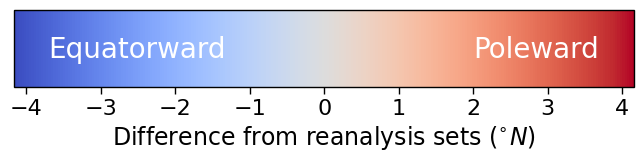

In [117]:
fig, ax = plt.subplots(1, figsize=(8, 1))
# sns.pointplot(df_diff_djf_ens_mean.T[mean_order.index], palette=rbr_cmap(norm(similiarity_scores_djf)), capsize=.3, estimator='mean', errorbar=errorbar_to_use,\
#               markers = '_', errwidth=1.5, ax=axes[0], join=False);
# ax.figure.colorbar(sm)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm_djf, cmap=rbr_cmap),
             cax=ax, orientation='horizontal', label='Similarity to Reanalysis')
cbar.ax.set_xlabel('Difference from reanalysis sets $(^{\circ}N)$', size=17)
ticklabs = cbar.ax.get_xticklabels();
cbar.ax.set_xticklabels(ticklabs, fontsize=16);
cbar.ax.text(s="Poleward", x=2, y=0.38, size=20, color='white')
cbar.ax.text(s="Equatorward", x=-3.7, y=0.38, size=20, color='white')
# fig.savefig('figures/figure_4_cbar.png', bbox_inches='tight', dpi=150)

In [118]:
cmap_norm = norm_djf # norm_son

In [119]:
df_diff_ens_mean.loc[season_hist_and_future_mean_diffs_w_mean_ensemble_means.index]

,Woollings et al. 2010,Barnes & Polvani 2013,Grise & Polvani 2014,Barnes & Simpson 2017,Zappa et al. 2018,Kerr et al. 2020
ACCESS-CM2,0.418530,0.410777,0.391282,0.260541,0.241211,-0.029816
ACCESS-ESM1-5,-0.176503,-0.158082,-0.145846,-0.029541,-0.332258,-0.170983
CESM2-WACCM,1.193215,1.182625,0.956946,1.092540,0.678953,0.336195
CMCC-CM2-SR5,2.421246,2.362236,2.240259,1.951196,1.258366,1.336146
CMCC-ESM2,1.066681,1.120054,1.054267,1.019244,0.663229,0.621949
CNRM-CM6-1,0.826252,0.814204,0.730786,0.823811,0.458317,0.307420
CNRM-ESM2-1,-0.102633,-0.102008,-0.206383,-0.280796,-0.285648,-0.025228
CanESM5,2.186366,2.193498,2.123775,2.325458,1.574990,1.622582
EC-Earth3,2.003799,1.940024,1.800987,1.618012,1.373113,0.971775
EC-Earth3-CC,1.808228,1.725528,1.768452,2.296878,1.613416,1.183076


In [120]:
df_future_hist_diff_season_by_model[["Annual mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna().quantile([0.025, 0.975])

,Annual mean,DJF,MAM,JJA,SON
0.025,-0.422469,-0.689745,-0.667115,-2.166591,-0.250626
0.975,1.926078,2.606639,2.097084,2.310160,2.625023


In [121]:
df_diff_ens_mean.loc[season_hist_and_future_mean_diffs_w_mean_ensemble_means.index].mean().mean()

0.8872069009035691

In [141]:
df_diff_ens_mean.loc[season_hist_and_future_mean_diffs_w_mean_ensemble_means.index].quantile([0.025, 0.975])

,Woollings et al. 2010,Barnes & Polvani 2013,Grise & Polvani 2014,Barnes & Simpson 2017,Zappa et al. 2018,Kerr et al. 2020
0.025,-0.381467,-0.382436,-0.701685,-0.338282,-0.764709,-0.700251
0.975,2.568560,2.530153,2.457539,2.415815,2.597062,1.850208


In [123]:
df_diff_djf_ens_mean.T[mean_order_djf.index].max() - df_diff_djf_ens_mean.T[mean_order_djf.index].min()

NorESM2-LM          0.585841
CanESM5             0.750468
CMCC-CM2-SR5        1.162880
MPI-ESM1-2-LR       0.687296
NorESM2-MM          1.705605
MRI-ESM2-0          0.681928
EC-Earth3-CC        1.113802
EC-Earth3           1.032024
HadGEM3-GC31-MM     0.799519
MIROC6              1.082312
MIROC-ES2L          0.758145
MPI-ESM1-2-HR       0.819171
GFDL-CM4            0.851908
CMCC-ESM2           0.498106
CESM2-WACCM         0.857020
EC-Earth3-Veg-LR    1.116612
INM-CM4-8           0.479883
INM-CM5-0           0.280571
CNRM-CM6-1          0.518832
IPSL-CM6A-LR        0.439561
ACCESS-CM2          0.448346
TaiESM1             0.961549
KACE-1-0-G          0.533465
CNRM-ESM2-1         0.260421
ACCESS-ESM1-5       0.302717
HadGEM3-GC31-LL     0.603759
FGOALS-g3           0.744862
UKESM1-0-LL         0.652608
dtype: float64

In [124]:
df_diff_djf_ens_mean.T[mean_order_djf.index].mean().mean()

0.8872069009035691

In [125]:
df_diff_djf_ens_mean.T[mean_order_djf.index].quantile([0.025, 0.975]).min(axis=1), df_diff_djf_ens_mean.T[mean_order_djf.index].quantile([0.025, 0.975]).max(axis=1) 

(0.025   -0.853736
 0.975   -0.194810
 dtype: float64,
 0.025    2.329832
 0.975    2.905073
 dtype: float64)

In [126]:
multi_r_models_w_all_models[mean_order_djf.index].quantile([0.025, 0.975]).min(axis=1), multi_r_models_w_all_models[mean_order_djf.index].quantile([0.025, 0.975]).max(axis=1) 

(0.025   -1.561118
 0.975    0.109732
 dtype: float64,
 0.025    1.083154
 0.975    3.474671
 dtype: float64)

In [127]:
multi_r_models_w_all_models[mean_order_djf.index]

,NorESM2-LM,CanESM5,CMCC-CM2-SR5,MPI-ESM1-2-LR,NorESM2-MM,MRI-ESM2-0,EC-Earth3-CC,EC-Earth3,HadGEM3-GC31-MM,MIROC6,...,CNRM-CM6-1,IPSL-CM6A-LR,ACCESS-CM2,TaiESM1,KACE-1-0-G,CNRM-ESM2-1,ACCESS-ESM1-5,HadGEM3-GC31-LL,FGOALS-g3,UKESM1-0-LL
0,NaN,2.634396,NaN,NaN,NaN,NaN,NaN,NaN,1.341278,NaN,...,1.995679,0.265404,NaN,NaN,NaN,0.064595,-0.602643,-0.020214,NaN,-0.037256
1,NaN,2.786439,NaN,NaN,NaN,NaN,NaN,NaN,1.336470,NaN,...,1.922337,0.290777,NaN,NaN,NaN,0.092876,-0.536366,-0.004519,NaN,-0.037488
2,NaN,2.728611,NaN,NaN,NaN,NaN,NaN,NaN,0.990926,NaN,...,1.747739,0.151297,NaN,NaN,NaN,-0.272675,-0.633901,-0.191545,NaN,-0.377858
3,NaN,2.759530,NaN,NaN,NaN,NaN,NaN,NaN,1.641956,NaN,...,1.389691,0.191074,NaN,NaN,NaN,0.116126,-0.667853,0.009259,NaN,-0.111111
4,NaN,1.874469,NaN,NaN,NaN,NaN,NaN,NaN,0.829989,NaN,...,1.245178,0.555034,NaN,NaN,NaN,-0.230701,-0.708718,-0.404885,NaN,-0.320943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,NaN,1.612455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,1.398715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,1.943044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,1.086334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
multi_r_models_w_all_models[mean_order_djf.index].dropna(how='all').quantile([0.05, 0.95])

,NorESM2-LM,CanESM5,CMCC-CM2-SR5,MPI-ESM1-2-LR,NorESM2-MM,MRI-ESM2-0,EC-Earth3-CC,EC-Earth3,HadGEM3-GC31-MM,MIROC6,...,CNRM-CM6-1,IPSL-CM6A-LR,ACCESS-CM2,TaiESM1,KACE-1-0-G,CNRM-ESM2-1,ACCESS-ESM1-5,HadGEM3-GC31-LL,FGOALS-g3,UKESM1-0-LL
0.05,NaN,1.161363,NaN,NaN,NaN,NaN,NaN,NaN,0.667430,NaN,...,-0.121642,-0.922715,NaN,NaN,NaN,-0.492300,-0.686242,-0.918067,NaN,-1.457032
0.95,NaN,2.943695,NaN,NaN,NaN,NaN,NaN,NaN,1.931199,NaN,...,1.791389,1.375395,NaN,NaN,NaN,0.103338,0.462162,0.171396,NaN,0.109954


/tmp/ipykernel_29558/1629922006.py:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.pointplot(df_diff_djf_ens_mean.T[mean_order_djf.index], palette=rbr_cmap(cmap_norm(similiarity_scores_djf)), capsize=.3, estimator='mean', errorbar=errorbar_to_use,\
/tmp/ipykernel_29558/1629922006.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Annual mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
/tmp/ipykernel_29558/1629922006.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(cols_to_use, rotation=90);
/tmp/ipykernel_29558/1629922006.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].se

Text(-0.6, 3.25, 'DJF')

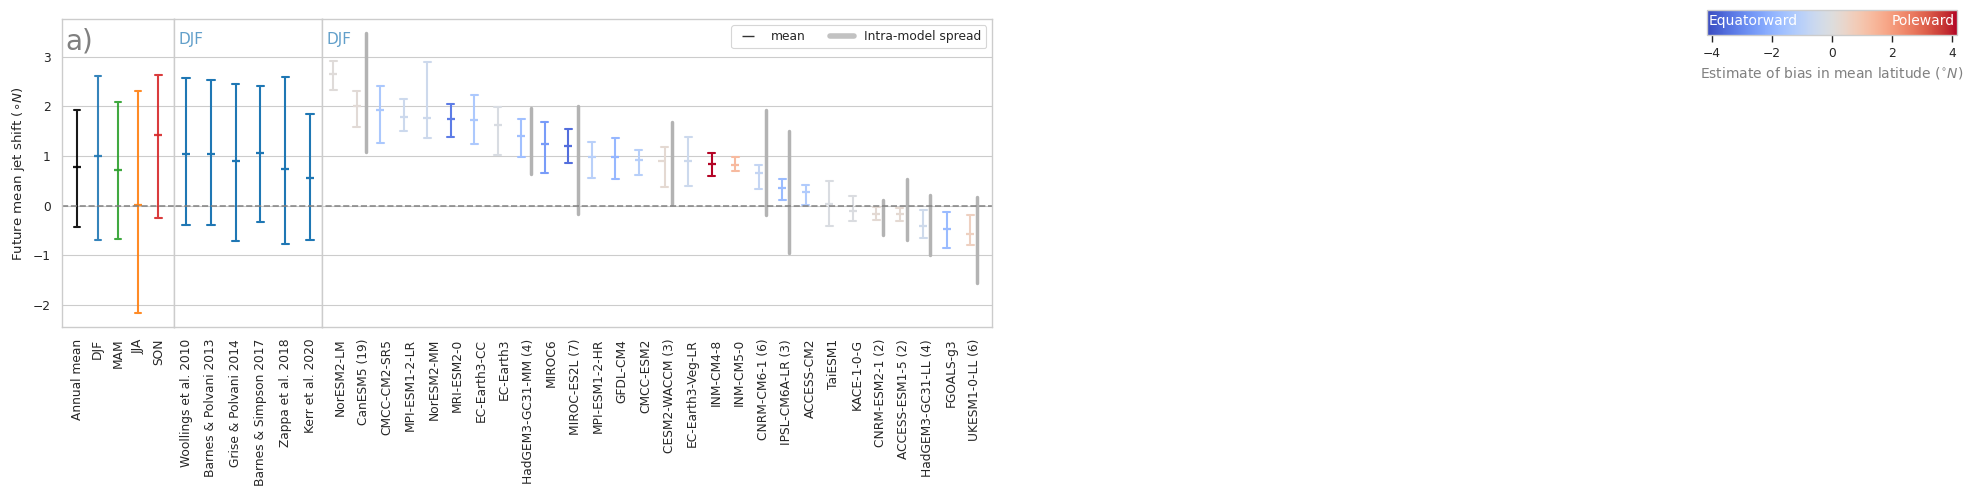

In [149]:
sns.set_context('paper')
sns.set_style('whitegrid')
cols_to_use = ['Woollings et al. 2010', 'Barnes & Polvani 2013', 'Grise & Polvani 2014', 'Barnes & Simpson 2017',\
               'Zappa et al. 2018','Kerr et al. 2020'] # 'Barnes & Polvani 2015'
errorbar_to_use = ('pi', 95)

fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey=True, width_ratios=[0.15, 0.2, 0.9])
plt.subplots_adjust(wspace=0)

sns.pointplot(df_future_hist_diff_season_by_model[["Annual mean", 'DJF', 'MAM', 'JJA', 'SON']].dropna(), capsize=.3, estimator='mean', errorbar=errorbar_to_use,\
              markers = '_', err_kws={'linewidth': 1.5},  linestyle='none', palette=['k', 'C0', 'C2', 'C1', 'C3'], ax=axes[0])
sns.pointplot(df_diff_ens_mean.loc[season_hist_and_future_mean_diffs_w_mean_ensemble_means.index], color=color_to_use, capsize=.3, estimator='mean', errorbar=errorbar_to_use,\
              markers = '_', err_kws={'linewidth': 1.5},  linestyle='none', ax=axes[1])
sns.pointplot(df_diff_djf_ens_mean.T[mean_order_djf.index], palette=rbr_cmap(cmap_norm(similiarity_scores_djf)), capsize=.3, estimator='mean', errorbar=errorbar_to_use,\
              markers = '_', err_kws={'linewidth': 1.5},  linestyle='none', ax=axes[2]);
offset = matplotlib.transforms.ScaledTranslation(-(5/72.), 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].get_transform()
axes[2].set_transform(trans + offset)
for line in axes[2].lines:
    trans = line.get_transform()
    line.set_transform(trans + offset)
    
sns.pointplot(multi_r_models_w_all_models[mean_order_djf.index], capsize=.0, estimator='mean', errorbar=errorbar_to_use,\
              markers='', err_kws={'linewidth': 2.5}, linestyle='none', color='0.7',  ax=axes[2]);

# May not appear in the correct place in the notebook, but necessary for saving
inset_ax2 = inset_axes(axes[2],
                    width=2.5,                     # inch
                    height=0.25,                    # inch
                    bbox_transform=ax.transAxes, # relative axes coordinates
                    bbox_to_anchor=(2.45,1.05),    # relative axes coordinates
                    )                       # loc=lower left corner
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm_djf, cmap=rbr_cmap),
             cax=inset_ax2, orientation='horizontal', label='Similarity to Reanalysis')
cbar.ax.set_xlabel('Estimate of bias in mean latitude $(^{\circ}N)$', color='grey', size=10)
# ticklabs = cbar.ax.get_xticklabels();
# cbar.ax.set_xticklabels(ticklabs, fontsize=7);
cbar.ax.text(s="Poleward", x=2, y=0.38, size=10, color='white')
cbar.ax.text(s="Equatorward", x=-4.1, y=0.38, size=10, color='white')

offset = matplotlib.transforms.ScaledTranslation(2/72., 0, axes[2].figure.dpi_scale_trans)
trans = axes[2].get_transform()
axes[2].set_transform(trans + offset)
for line in axes[2].lines[len(axes[2].lines)//2:]:
    trans = line.get_transform()
    line.set_transform(trans + offset)

# for text
lowest_ylim = 100
for ax in axes:
    if ax.get_ylim()[0] < lowest_ylim:
        lowest_ylim = ax.get_ylim()[0]
        
axes[0].set_xticklabels(["Annual mean", 'DJF', 'MAM', 'JJA', 'SON'], rotation=90);
axes[1].set_xticklabels(cols_to_use, rotation=90);
axes[2].set_xticklabels(sorted_models_with_group_count, rotation=90);
plt.setp(axes[0].collections, alpha=.8); #for the markers
plt.setp(axes[0].lines, alpha=.9);    #for the lines
black_line = mlines.Line2D([], [], color='k', marker='_', linestyle='None',
                          markersize=8, alpha=.8, label='mean')
grey_line = mlines.Line2D([0], [0], color='0.7', linestyle='-', lw=4,
                        alpha=.8, label='Intra-model spread')
axes[2].legend(handles=[black_line, grey_line], ncols=2)
axes[0].hlines(-0, -0.75, 5.5, 'grey', '--', alpha=.9)
axes[1].hlines(-0, -1.5, 7.75, 'grey', '--', alpha=.9)
axes[2].hlines(-0, -1.75, 27.75, 'grey', '--', alpha=.9)
axes[0].set_xlim(-0.75, 4.75)
axes[1].set_xlim(-0.5, 5.5)
axes[2].set_xlim(-0.75, 27.75)

axes[0].text(s="a)", x=-0.6, y=3.15, color='grey', size=20)

# for ax in axes: # for SON
#     ax.set_ylim(-2.5, 4.1)
# axes[0].spines['right'].set_visible(False)
# axes[1].spines['left'].set_visible(False)
axes[0].set_ylabel("Future mean jet shift (${\circ N}$)")
axes[1].text(s=season_name.upper(), x=-0.3, y=3.25, fontsize=11, alpha=.7, color=color_to_use)
axes[2].text(s=season_name.upper(), x=-0.6, y=3.25, fontsize=11, alpha=.7,  color=color_to_use)
# fig.savefig(f'figures/figure_4_{season_name}.png', bbox_inches='tight', dpi=300)

## Save data

In [ ]:
# multi_r_models_djf.to_csv('outputs/multi_r_models_djf.csv', index=False)
# multi_r_models_mam.to_csv('outputs/multi_r_models_mam.csv', index=False)
# multi_r_models_jja.to_csv('outputs/multi_r_models_jja.csv', index=False)
# multi_r_models_son.to_csv('outputs/multi_r_models_son.csv', index=False)